# Preparing ARIA standard GUNW products layers for time-series analysis using ariaTSsetup.py

**Author**: Simran Sangha, David Bekaert - Jet Propulsion Laboratory

This notebook provides an overview of the functionality included in the **ariaTSsetup.py** program. Specifically, we give examples on how to extract data and meta-data layers from ARIA Geocoded UNWrapped interferogram (GUNW) products over a user defined area of interest and prepare the data into a stack for time-series ingestion.

In this notebook, we will demonstrate how to:
- Extract data layers (unwrapped phase, coherence) and imaging geometry layers (azimuth angle, incidence angle, look angle) necessary for building time-series
- Prepare the extracted data into a stack for time-series ingestion

    
<div class="alert alert-warning">
Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. The overview sections do not need to be run in order. In the application section the ariaTSsetup commandline call at the top must be run first, but the rest of the section does not need to be run in order.
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
    
- GDAL uses "HDF5" driver instead of "netCDF/Network Common Data Format" on GUNW products. Verify GDAL version >= 3.
- ARIA-tools needs to be installed to run this notebook
</div>


<div class="alert alert-info">
    <b>Terminology:</b>
    
- *Acquisition*: An image acquired by the satellite for a given date and time.
- *Interferogram*: An unwrapped image containing the surface displacement accumulated between two acquisitions.
- *Frame*: Outline of a product ground footprint.
- *Along-track*: The direction along satellite flight path. 
    </div>
    

## Prep A. Initial setup of the notebook

Below we set up the directory structure for this notebook exercise. In addition, we load the required modules into our python environment using the **`import`** command. We also explicitly enable exceptions for GDAL as this allows us to capture GDAL errors.

In [1]:
import os
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter, StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

    

## Defining the home and data directories at the processing location
work_dir = os.path.abspath(os.getcwd())
tutorial_home_dir = os.path.abspath(os.getcwd())
print("Work directory: ", work_dir)
print("Tutorial directory: ", tutorial_home_dir)

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

# Verifying if ARIA-tools is installed correctly
try:
    import ARIAtools.shapefile_util as shputil
except:
    raise Exception('ARIA-tools is missing from your PYTHONPATH')
        
os.chdir(work_dir)

Work directory:  /Volumes/BB_1TB/ARIA-tools-docs_git/JupyterDocs/ariaTSsetup
Tutorial directory:  /Volumes/BB_1TB/ARIA-tools-docs_git/JupyterDocs/ariaTSsetup


Below we define a plotting function that will be used throughout the notebook for plotting GDAL compatible datasets on a map.

In [2]:
def plot_layer(path_layer, lay_type=None, cmap=None, n_bands=None, **kwargs):
    """ 
        path_layers is a string to the GDAL compatible dataset to be plotted
    """
    
    if not lay_type: 
        lay_type = os.path.dirname(path_layer)
    title = [os.path.basename(lay_type)]
    
    ## get the lon lat bounds
    ds       = gdal.Open(path_layer, gdal.GA_ReadOnly)
    trans    = ds.GetGeoTransform()
    extent   = [trans[0], trans[0] + ds.RasterXSize * trans[1], trans[3] + ds.RasterYSize*trans[5], trans[3]]
    
    ## loading the data
    if not n_bands:
        n_bands  = ds.RasterCount
    lst_arrs = []
    
    for band in range(n_bands):
        raster = ds.GetRasterBand(band+1)
        arr    = raster.ReadAsArray()
        try:
            NoData = raster.GetNoDataValue()
            arr = np.ma.masked_where((arr>1e20) |(arr==NoData),arr )
        except:
            print('Could not find a no-data value...')
            arr = np.ma.masked_where(arr>1e20,arr)
        
        lst_arrs.append(arr)

    ds = None
    if n_bands < 4:
        nrows = 1; ncols = n_bands
    else:
        raise Exception('Number of bands currently unsupported')
        
    
    ## initializing a figure
    fig, axes = plt.subplots(figsize=(12,9), ncols=ncols, nrows=nrows, sharex='col', sharey='row')
    axes = axes if isinstance(axes, np.ndarray) else np.array(axes)
    axe  = axes.ravel() 
    cmap = plt.cm.Greys_r
    cmap.set_under('black')
    
    ## definging the plotting options for differnt layer types
    # Amplitude:
    if lay_type.endswith('amplitude'): 
        # will fix the maximum amplitude bound
        vmin=None
        vmax = 2000 
    # Coherence:
    elif lay_type.endswith('coherence'): 
        # has fixed range between 0-1
        vmin=0
        vmax = 1
    # Incidence angle:
    elif lay_type.endswith('incidenceAngle'): 
        vmin=None
        vmax=None
    # water
    elif lay_type.startswith('water'):
        # no bounds needed will be a 0/1 mask
        vmin=0
        vmax=1
        cmap='Greys'
    # deformation or unwrapped phase
    elif lay_type.startswith('defo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
    elif lay_type.startswith('terr') or lay_type.startswith('topo'): 
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.terrain
    elif lay_type == 'ENU':
        vmin=None
        vmax=None
        title = ['East', 'North', 'Up']
        fig.subplots_adjust(wspace=0.5)

    else:
        # let the data drive the bounds
        vmin=None
        vmax=None
        # change colormap to a warm type
        cmap=plt.cm.coolwarm
        
    # plotting the data    
    for i, ax in enumerate(axe):
        im   = ax.imshow(lst_arrs[i], cmap=cmap, vmin=vmin, vmax=vmax, extent=extent)
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='5%', pad=0.25)
        if lay_type == 'ENU':
            fig.colorbar(im, cax=cax, format=FuncFormatter(lambda x, y: '{:.3f}'.format(x)))
        elif lay_type.startswith('water'):
            fig.colorbar(im, cax=cax, ticks=[vmin, vmax])
        else:
            fig.colorbar(im, cax=cax)

        ax.set_title(title[i], fontsize=15)
        ax.grid(False)

    axe[0].set_ylabel('latitude', labelpad=15, fontsize=15)
    axe[int(np.floor(n_bands/2))].set_xlabel('longitude', labelpad=15, fontsize=15)

## Prep B: Download the data

We will use San Francisco as the study area for this tutorial (see **Fig. 1**). Specifically, we will use Sentinel-1 interferograms generated on track 42, spanning the start of the Sentinel-1 mission phase in late 2014 up until the present day.

ARIA provides unwrapped interferograms as GUNW products. As the spatial extent of a product is roughly the size of a single Sentinel-1 SLC frame (250km x 250km), it is likely that a given interferogram over this study area is composed of multiple adjacent GUNW frames or products.

<img src="./support_docs/track_042.png" alt="track" width="600">

<blockquote><b>Fig. 1</b> Image of San Francisco study area centered along Track 42. Blue and white boxes denote footprint of a product and the bounding box of our study area. Faults from USGS Quaternary fault catalog are plotted in background. For interpretation of fault trace colors, refer to see <a href="https://earthquake.usgs.gov/hazards/qfaults/">USGS fault catalogue website </a>. </blockquote>

### ARIA GUNW products

The GUNW product is an InSAR surface displacement product derived from Sentinel-1 SAR data and packaged as netCDF4 files. GUNW products contain both data and meta-data layers such as the interferometric amplitude, filtered unwrapped phase, filtered coherence, connected components, perpendicular and parallel baselines, incidence, azimuth and look angles. A detailed overview of the ARIA GUNW product with respect to processing, formatting, sampling, and data layers can be found on the [ARIA website](https://aria.jpl.nasa.gov/node/97).

### Download options

GUNW products are hosted at the ASF DAAC and can be downloaded from the [ARIA-products page](https://aria-products.jpl.nasa.gov) and as beta products from the [ASF DAAC data search page](https://search.asf.alaska.edu/#/). If you know the GUNW filename of the product, you can also build a download link by appending the GUNW filename to **https://<i></i>grfn.asf.alaska.edu<i></i>/door/download/** . 

Alternatively, you can use the **`ariaDownload.py`** program provided within the ARIA-tools package to download data using a command-line interface. This program wraps around the ASF DAAC API and allows for search sub-setting of GUNW products based on track number, geometry (ascending or descending), as well as spatial and temporal bounding boxes criteria. For a full description of the **`ariaDownload.py`** program, see the [ariaDownload Tutorial](https://github.com/aria-tools/ARIA-tools-docs/blob/master/JupyterDocs/ariaDownload/ariaDownload_tutorial.ipynb).

<div class="alert alert-warning">
<b>Potential download failure:</b> 
GUNW products are hosted at the NASA ASF DAAC. Downloading them requires a NASA Earthdata URS user login and requires users to add “ARIA Product Search” to their URS approved applications
    
<b>Login Credentials:</b>
Save your user-name and password to a `.netrc` file in your `$HOME` directory, or pass the combination explicitly using `ariaDownload.py --user <user> --pass <pass>`.
</div>

Below we will use **`ariaDownload.py`** to download all the GUNW products on track *42* (**`--track`** option) over the San Francisco area *'37.25 38.1 -122.6 -121.75'* (**`-bbox`** SNWE option) corresponding to all interferograms produced starting *2014* (**`--s`** option) through to the present day. These products will be stored in a *products* subfolder created in your specified *work directory* (**`-w`** option).

<div class="alert alert-danger">
<b>Download</b>:     
    
- Can take up to 40 mins, so this is a good moment to take a coffee-break! - The ***jupyter notebook* does not allow for interactive entering of your user-name and password, use the *jupyter terminal* instead** with the same command for interactive use.
</div>

In [3]:
!ariaDownload.py --track 42 --bbox '37.25 38.1 -122.6 -121.75'

https://api.daac.asf.alaska.edu/services/search/param?asfplatform=Sentinel-1%20Interferogram%20(BETA)&processingLevel=GUNW_STD&output=JSON&relativeOrbit=42&bbox=-122.6,37.25,-121.75,38.1
 > attempting to download https://urs.earthdata.nasa.gov/profile
 > Re-using previous cookie jar.
 > Download file S1-GUNW-D-R-042-tops-20200310_20190304-140804-38619N_36645N-PP-27a7-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20200310_20190304-140804-38619N_36645N-PP-27a7-v2_0_2.nc. 
 > Download file S1-GUNW-D-R-042-tops-20200310_20200122-140804-38619N_36645N-PP-a722-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20200310_20200122-140804-38619N_36645N-PP-a722-v2_0_2.nc. 
 > Download file S1-GUNW-D-R-042-tops-20200310_20200203-140804-38619N_36645N-PP-3954-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20200310_20200203-140804

 > Download file S1-GUNW-D-R-042-tops-20191111_20191018-140807-38619N_36646N-PP-a23e-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20191111_20191018-140807-38619N_36646N-PP-a23e-v2_0_2.nc. 
 > Download file S1-GUNW-D-R-042-tops-20191111_20191030-140807-38619N_36646N-PP-b286-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20191111_20191030-140807-38619N_36646N-PP-b286-v2_0_2.nc. 
 > Download file S1-GUNW-D-R-042-tops-20191030_20181023-140807-38619N_36646N-PP-01b0-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20191030_20181023-140807-38619N_36646N-PP-01b0-v2_0_2.nc. 
 > Download file S1-GUNW-D-R-042-tops-20191030_20190924-140807-38619N_36646N-PP-88de-v2_0_2.nc exists! 
 > Skipping download of https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20191030_20190924-140807-38619N_36646N-PP-88de-v2_0_2.nc. 


 > Downloaded 64471753 of 64471753 bytes (100.00%)
Downloaded 64471753b in 13.53secs, Average Rate: 4.54MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190912_20180905-140807-38619N_36646N-PP-24b6-v2_0_2.nc?userid=bbuzz&Expires=1594781619&Signature=u2sZ3a7gDTIzULLdNzFsdSxiczW65CAib2Wvy35qRezhiKOMpi~T7fwox6H3tUVBWCo06c6qycjCqm~0P8eUa5Tt~rBRSwhevKRLGKQeuhvCe8k5YsClfiKNgZg-jLq0fvsAhp5D9cOrLu9JfcO7e69AAxdh5S6JQSMHt3s9ftw_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(51/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190912_20180905-140807-38619N_36646N-PP-24b6-v2_0_2.nc
 > Downloaded 68255433 of 68255433 bytes (100.00%)
Downloaded 68255433b in 5.28secs, Average Rate: 12.33MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190912_20190807-140807-38619N_36646N-PP-57fa-v2_0_2.nc?userid=bbuzz&Expires=1594781624&Signature=rnreUa14P

 > Downloaded 64576841 of 64576841 bytes (100.00%)
Downloaded 64576841b in 5.20secs, Average Rate: 11.85MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190807_20180731-140805-38620N_36646N-PP-24c2-v2_0_2.nc?userid=bbuzz&Expires=1594781689&Signature=1W3gespzIJLrIPUADtJJvl4HeYiJH1Vy2pHJPZADfQSE8QO2UvpL8pSuKe6ZXF~haxpCa3~tnCfA33ulNkHOXGQ88wF-NrZisGeOVlp5JTpzjfrGLPGM~079TziJsXTze-PHTaFdy1W~o3aqMk-t7iLRAwQKEEwYU1QUjfn7fVs_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(64/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190807_20180731-140805-38620N_36646N-PP-24c2-v2_0_2.nc
 > Downloaded 66441779 of 66441779 bytes (100.00%)
Downloaded 66441779b in 5.02secs, Average Rate: 12.61MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190807_20190702-140805-38620N_36646N-PP-1b74-v2_0_2.nc?userid=bbuzz&Expires=1594781694&Signature=NQEMTkDOz

 > Downloaded 67180771 of 67180771 bytes (100.00%)
Downloaded 67180771b in 5.69secs, Average Rate: 11.27MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190702_20180625-140802-38620N_36646N-PP-97a8-v2_0_2.nc?userid=bbuzz&Expires=1594781791&Signature=tiM99WvSEBn0T7dMTLUsg1GmkdEeeR0cFpevPHisVohsuNMhOfJvGzIRJEeCW2Ln9WVswVSij4VnJrMHhRQQYMRp-NYlYLrkc05pDIvmn1E7qQiWHuStBsVtvDgVvUvQhedP8c4XZdbNFOGNMLtRDVOVz4G0-ZLXD7oHtjZejCs_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(77/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190702_20180625-140802-38620N_36646N-PP-97a8-v2_0_2.nc
 > Downloaded 68179554 of 68179554 bytes (100.00%)
Downloaded 68179554b in 4.89secs, Average Rate: 13.30MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190702_20190527-140802-38620N_36646N-PP-5ec5-v2_0_2.nc?userid=bbuzz&Expires=1594781796&Signature=f-9UdAAD8

 > Downloaded 67988839 of 67988839 bytes (100.00%)
Downloaded 67988839b in 5.30secs, Average Rate: 12.23MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190608_20190515-140801-38620N_36646N-PP-12fd-v2_0_2.nc?userid=bbuzz&Expires=1594781895&Signature=kBZjMI7oWYHRjEdDKMDP5LxCOZyRcVspjbMPgMV32Vx3olQQ949zpXjjJMSHjOmU7y-t-vhIYzORyeEsSX6i4zWqWfLjCK0XggcEzjNjdJcQ14UmgVHx6zJ4bQAxsjORDEJZWvtHWew5M5RdYGLFIZFF8tbaO310hVZ9XV29JMw_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(89/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190608_20190515-140801-38620N_36646N-PP-12fd-v2_0_2.nc
 > Downloaded 65704898 of 65704898 bytes (100.00%)
Downloaded 65704898b in 7.02secs, Average Rate: 8.92MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190608_20190527-140801-38620N_36646N-PP-b45d-v2_0_2.nc?userid=bbuzz&Expires=1594781902&Signature=vHAZCQXl~e

 > Downloaded 68037894 of 68037894 bytes (100.00%)
Downloaded 68037894b in 4.93secs, Average Rate: 13.17MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190503_20180426-140759-38620N_36646N-PP-802a-v2_0_2.nc?userid=bbuzz&Expires=1594781968&Signature=WNTMCWWygone-xdtAJzjkjQc-LhnudJduCPjM7KiGCqmDc365qAe0LHCM22kHUns1sXZHylp7w5FI9wyfc6dOvbDG9J-h5eFDpS-KNcFBwNPP3VcN6BAi53aJL8y3pIywxbACG29H972ki0JJU3djbOBreDBmghFrnT9bDhAKOM_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(102/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190503_20180426-140759-38620N_36646N-PP-802a-v2_0_2.nc
 > Downloaded 68362252 of 68362252 bytes (100.00%)
Downloaded 68362252b in 5.73secs, Average Rate: 11.37MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190503_20190328-140759-38620N_36646N-PP-5118-v2_0_2.nc?userid=bbuzz&Expires=1594781974&Signature=F-VFohve

 > Downloaded 66769306 of 66769306 bytes (100.00%)48 of 66769306 bytes (2.69%)6 bytes (2.94%)12960 of 66769306 bytes (4.66%)f 66769306 bytes (78.19%)f 66769306 bytes (85.29%)
Downloaded 66769306b in 8.05secs, Average Rate: 7.91MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190409_20190328-140758-38619N_36645N-PP-c239-v2_0_2.nc?userid=bbuzz&Expires=1594782049&Signature=fJ5ZdwBHBLAn8FGF5vmatPvvxiB9avQlbWpvdP6Zfy5W3VmDV8j~UNDPU4q~J9uZFfnGIRqxs2vRL5-cGJEbkxmu62QtM4Vo3Nv0GNH2jfOQfaQ3fnM2AwKE5K42eWTAnSJaVElkHzKkGot2laru8WT~XZftSBZuHnYt6ayBGKo_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(115/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190409_20190328-140758-38619N_36645N-PP-c239-v2_0_2.nc
 > Downloaded 65790135 of 65790135 bytes (100.00%)
Downloaded 65790135b in 4.98secs, Average Rate: 12.60MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GU

 > Downloaded 68679956 of 68679956 bytes (100.00%)
Downloaded 68679956b in 5.16secs, Average Rate: 12.68MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190208_20190103-140758-38619N_36645N-PP-a6ce-v2_0_2.nc?userid=bbuzz&Expires=1594782224&Signature=lGZWnxmSQrWqqPf5STW6TgGcMGnBlGWM9PKNWoHuSkuPSTrZr~aUhrHrRsySiJHQ1mb~TSISskcJFBsPfEYNAqWgXrmBjDavcPEBu0b5vCzsMjt23IhygdZ21mbVpf0xbLmWGA9VxfWtVdIUTKjhOrGOA~rwcf73GBH0HEvG3Mo_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(139/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190208_20190103-140758-38619N_36645N-PP-a6ce-v2_0_2.nc
 > Downloaded 64113724 of 64113724 bytes (100.00%)
Downloaded 64113724b in 4.98secs, Average Rate: 12.28MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20190208_20190115-140758-38619N_36645N-PP-8a6b-v2_0_2.nc?userid=bbuzz&Expires=1594782229&Signature=Wfrfw~pl

 > Downloaded 68213480 of 68213480 bytes (100.00%)16 of 68213480 bytes (2.38%)
Downloaded 68213480b in 12.18secs, Average Rate: 5.34MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20181210_20171203-140800-38620N_36646N-PP-abe9-v2_0_2.nc?userid=bbuzz&Expires=1594782424&Signature=DJVPGhhASAiLGnAXBmEaoGqwgOs7Ry0hE8traWQidg5IIFEQzNa6krdnfX8oLrityf8qrO6FZCPo5Qj6K7tD1LQircZTzZ~sJK~dbTyDpItVyDPb9GVAIrHtsRvdNTqxsW0EysvGGCIeV01U8NQ-Is2rXO~1CFgMM6GvYitdQL0_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(163/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20181210_20171203-140800-38620N_36646N-PP-abe9-v2_0_2.nc
 > Downloaded 67809692 of 67809692 bytes (100.00%)12 of 67809692 bytes (3.46%)92896 of 67809692 bytes (5.59%)2 bytes (5.85%)f 67809692 bytes (28.05%)f 67809692 bytes (35.48%)f 67809692 bytes (35.96%)f 67809692 bytes (57.96%)
Downloaded 67809692b in 10.94secs, Average Rate: 5.91MB/sec
 > 'Temporary' Re

 > Downloaded 63978893 of 63978893 bytes (100.00%)
Downloaded 63978893b in 7.09secs, Average Rate: 8.61MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20181116_20181023-140801-38619N_36645N-PP-6a24-v2_0_0.nc?userid=bbuzz&Expires=1594782583&Signature=1LX2VdHBwahGwMDHbXqD7iBZ8j1rGcmNq5KdTdVPLLAh1ZeA1N9qlRGKZc~iovdw7Yr-9sxTcQXvzR3dMC8goEO8UeAKQAnvPqany~AX-qoK0D429GntBbn-wa3Yxb9qWfLOTSGCzAXY87LyqR6G8HQBlL43Av4skmzyXCRbF3M_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(175/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20181116_20181023-140801-38619N_36645N-PP-6a24-v2_0_0.nc
 > Downloaded 65025473 of 65025473 bytes (100.00%)
Downloaded 65025473b in 8.48secs, Average Rate: 7.32MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20181116_20181104-140801-38619N_36645N-PP-7cc4-v2_0_0.nc?userid=bbuzz&Expires=1594782591&Signature=Xy19sN88BV

 > Downloaded 63565853 of 63565853 bytes (100.00%) 63565853 bytes (44.64%))f 63565853 bytes (54.23%)f 63565853 bytes (58.38%)f 63565853 bytes (63.42%)f 63565853 bytes (97.20%)
Downloaded 63565853b in 9.71secs, Average Rate: 6.24MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180917_20170817-140801-38619N_36645N-PP-c689-v2_0_2.nc?userid=bbuzz&Expires=1594782853&Signature=IJ3YY~g2stMDNs9HF1OD4vrym67XXPlGqnoCjRf3N1Aw6eZXu~PNtiEKUOGuzU6DXo0ycm9Vbmd92Zp1Hv9UDp168A26UV9st42-HUD1CAMP9NHNGK~BIqb9bI5LE~A6Ip1y7R1DomwAVXrZWR-5rQtOc69ae4wvHKD0q2vSMX0_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(197/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180917_20170817-140801-38619N_36645N-PP-c689-v2_0_2.nc
 > Downloaded 66633409 of 66633409 bytes (100.00%)88 of 66633409 bytes (2.02%)79904 of 66633409 bytes (5.37%)aded 6717440 of 66633409 bytes (10.08%)f 66633409 bytes (17.77%))f 66633409 bytes (45.49%)f 66633

 > Downloaded 62913109 of 62913109 bytes (100.00%)76 of 62913109 bytes (6.22%)9 bytes (6.50%)(12.28%)09 bytes (12.81%)f 62913109 bytes (22.40%)f 62913109 bytes (37.12%)f 62913109 bytes (37.64%)f 62913109 bytes (47.18%)f 62913109 bytes (53.69%)))f 62913109 bytes (59.85%)f 62913109 bytes (67.89%)f 62913109 bytes (76.79%)f 62913109 bytes (77.31%)f 62913109 bytes (81.93%)f 62913109 bytes (88.95%)f 62913109 bytes (95.73%)
Downloaded 62913109b in 31.42secs, Average Rate: 1.91MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180824_20170805-140800-38619N_36645N-PP-905e-v2_0_2.nc?userid=bbuzz&Expires=1594783005&Signature=u4ff114-2bi9c2Mr49qHU5iFxbjID3GTMQFjFEgZw3CZqRXMFvSZbQRft3bvPr-2TZjPWcBJ9bA0Mgz3b5~3PREyuht~iizq9Pd8YNHFoUQRVFt27hPpawjvTaCIkJQxKu7tqno9ZZB4SrneCdUktGHBsRrJntGJJTkPrVURlBI_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(207/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180824_20170805

 > Downloaded 64285332 of 64285332 bytes (100.00%)ytes (5.25%)2 bytes (6.19%)(12.69%)f 64285332 bytes (16.20%)f 64285332 bytes (29.27%)f 64285332 bytes (54.06%)f 64285332 bytes (74.61%)f 64285332 bytes (92.25%)f 64285332 bytes (92.76%)
Downloaded 64285332b in 18.11secs, Average Rate: 3.38MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180812_20180731-140759-38619N_36645N-PP-599f-v2_0_0.nc?userid=bbuzz&Expires=1594783262&Signature=RUzuGgKBK6rCYtzLn0aoigq2l7wcSVyzDmzU~Jga0q0WNTF588iSiE6SJtK~qs9o6JPyIumdbFhZdzPHJsEKHdk57RYdzqIC20hpCJdFi8cAnsg0tz4P75bsf4ue9863cW9F~wEtx0tEnxpYXCu7dToow6eYtYzwALC2ehMccQ0_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(216/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180812_20180731-140759-38619N_36645N-PP-599f-v2_0_0.nc
 > Downloaded 63706207 of 63706207 bytes (100.00%)ytes (4.82%)(13.62%)20%)f 63706207 bytes (16.20%)f 63706207 bytes (43.03%)f 63706207 bytes (45.

 > Downloaded 66214420 of 66214420 bytes (100.00%)36 of 66214420 bytes (2.26%)09280 of 66214420 bytes (5.75%)0 bytes (6.80%) Downloaded 6733824 of 66214420 bytes (10.17%)(13.60%)f 66214420 bytes (52.87%)f 66214420 bytes (67.61%)f 66214420 bytes (89.28%)f 66214420 bytes (92.44%)
Downloaded 66214420b in 17.57secs, Average Rate: 3.59MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180719_20180625-140758-38619N_36646N-PP-8345-v2_0_0.nc?userid=bbuzz&Expires=1594783488&Signature=2dVtLvNS4uzwIy8yt7cG3iYL0GcPp4rD4bLaMP9XTIe-y07WrST7rlR8D1zRLivC9ZBTj-tEbb8B0wCtPw0HrQ-ul8TZO9QPNjw1XeDIpPuBoEUKPKUd1tuHX7Njo~pavFk5tOZgW9-s2zbDFYuFEvgXjjQ6VE~Njla1WExNRLs_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(225/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180719_20180625-140758-38619N_36646N-PP-8345-v2_0_0.nc
 > Downloaded 65791779 of 65791779 bytes (100.00%).92%)04768 of 65791779 bytes (4.72%)9 bytes (6.03%)0

 > Downloaded 67301307 of 67301307 bytes (100.00%)60 of 67301307 bytes (2.19%)33568 of 67301307 bytes (6.44%)94%)f 67301307 bytes (35.63%)f 67301307 bytes (42.01%)f 67301307 bytes (51.26%)f 67301307 bytes (68.19%)f 67301307 bytes (71.21%)
Downloaded 67301307b in 17.84secs, Average Rate: 3.60MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180625_20180601-140756-38619N_36645N-PP-8565-v2_0_0.nc?userid=bbuzz&Expires=1594783710&Signature=OnQZhqv6wBLP-OMbqqdEfGwBHyFR54XqjTrkCT3s0z9vJAcOsRyeAyuefnYCNoF-C7mFx7rGoQ60IpZteuyRoCXzNlh8b~pl4vKRPTBnb4jXJxpzEjc3C31A00OdctMSRfs3gmo-gHWpKtvEQaE90PX42YG-5I-ZS5xG1OplQu4_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(235/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180625_20180601-140756-38619N_36645N-PP-8565-v2_0_0.nc
 > Downloaded 66272646 of 66272646 bytes (100.00%)ytes (3.47%)91744 of 66272646 bytes (8.74%)66%)(13.40%)f 66272646 bytes (24.38%)f 66272646 b

 > Downloaded 68010013 of 68010013 bytes (100.00%)72 of 68010013 bytes (5.61%)f 68010013 bytes (35.15%)f 68010013 bytes (35.63%)f 68010013 bytes (36.11%)f 68010013 bytes (50.10%)
Downloaded 68010013b in 18.53secs, Average Rate: 3.50MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180601_20180508-140755-38619N_36646N-PP-39f6-v2_0_0.nc?userid=bbuzz&Expires=1594783913&Signature=soKNRqtcoF5FPJwoVIfQkkerxVvhFHRWNtd7I5ZnoXIiqKC5OTHVlAf23kVIthJm1-IEJDcrVGLJBgczNYoXHhfIxaxuVHqplj11gGlj5lqtSQ2brM0k51HRaZbJL1D10WU2enb1YCvIiCdJxfLusohfy-EWMHa1ixB9SDl~acc_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(245/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180601_20180508-140755-38619N_36646N-PP-39f6-v2_0_0.nc
 > Downloaded 66027554 of 66027554 bytes (100.00%).36%)42304 of 66027554 bytes (9.45%)d 6766592 of 66027554 bytes (10.25%)Downloaded 7102464 of 66027554 bytes (10.76%)f 66027554 bytes (88.64%)
Downloade

 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180414_20180225-140752-38619N_36645N-PP-9f02-v2_0_2.nc?userid=bbuzz&Expires=1594784414&Signature=1A8nt7ObHjemdKEvLxYOZBEyOnTmv4-U60VVNztdmhNmJqqXJ9vLOcqrd3hBE4CUNoCm07F9ic5bebVqMBcrc5iquvW1sn8l90duS3h423Alt4vTM3rV2-inXLZ21wRRkcFEJZVN1z36o~CGitUoxK~EYfclPDUFn7VBTKpOPFs_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(264/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180414_20180225-140752-38619N_36645N-PP-9f02-v2_0_2.nc
 > Downloaded 67818104 of 67818104 bytes (100.00%)ytes (4.42%)f 67818104 bytes (16.44%)f 67818104 bytes (18.92%))f 67818104 bytes (69.99%)f 67818104 bytes (80.36%)f 67818104 bytes (87.56%)f 67818104 bytes (92.95%)
Downloaded 67818104b in 19.09secs, Average Rate: 3.39MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180414_20180321-140752-38619N_36645N-PP-30ad-v2_0_0.n

 > Downloaded 69021822 of 69021822 bytes (100.00%)24 of 69021822 bytes (9.46%)f 69021822 bytes (21.00%)f 69021822 bytes (37.02%)f 69021822 bytes (76.30%)f 69021822 bytes (78.13%)f 69021822 bytes (88.34%)f 69021822 bytes (93.50%)f 69021822 bytes (96.04%)f 69021822 bytes (97.98%)
Downloaded 69021822b in 21.88secs, Average Rate: 3.01MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180213_20180108-140751-38619N_36645N-PP-aba2-v2_0_2.nc?userid=bbuzz&Expires=1594784955&Signature=e5eGDky2XG5jaAFOpHGNp~~DnEYUaj8vTjJO812yBBQ80DBfKfMY0pP9CmvleMf2dZyxciC-AVeMgXlFctmHeC3cUAlrsty1FgHDPfK~K8vF7c6ppqDdXAwnR6LxHo5~Tbe2YWXveuKCNrDI3ZOJaekof2bEUy~gHOtznRknMZs_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(284/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180213_20180108-140751-38619N_36645N-PP-aba2-v2_0_2.nc
 > Downloaded 66293469 of 66293469 bytes (100.00%)44 of 66293469 bytes (8.43%)f 66293469 bytes (22.96%

 > Downloaded 66653918 of 66653918 bytes (100.00%) 66653918 bytes (50.92%)f 66653918 bytes (53.30%)f 66653918 bytes (74.05%)f 66653918 bytes (76.99%))f 66653918 bytes (89.81%)
Downloaded 66653918b in 25.49secs, Average Rate: 2.49MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20180120_20171215-140752-38619N_36645N-PP-38ba-v2_0_2.nc?userid=bbuzz&Expires=1594785203&Signature=5PheCAdqvnEHFOXy3cxu92ivohZbC9RlQCSLQwgjWG00FrG27mOso0hcQ-NcodTMti~KWkjbyL0-NP~UNzzdmOIWbC9aydsiMsMKgq0Ps0OqTZ7zhx3pSfinnjoVMimwxqEUomG3D1eFVdB72X~EzB22qemANcF7DabL9MTigd4_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(294/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180120_20171215-140752-38619N_36645N-PP-38ba-v2_0_2.nc
 > Downloaded 65657859 of 65657859 bytes (100.00%)68 of 65657859 bytes (2.55%)94%)f 65657859 bytes (15.73%)f 65657859 bytes (19.93%)f 65657859 bytes (70.23%)f 65657859 bytes (95.63%)
Downloaded 65657859b i

 > Downloaded 67232923 of 67232923 bytes (100.00%)36 of 67232923 bytes (3.45%)61248 of 67232923 bytes (6.93%)f 67232923 bytes (41.00%)f 67232923 bytes (49.86%)f 67232923 bytes (70.43%)f 67232923 bytes (74.74%)f 67232923 bytes (82.76%)f 67232923 bytes (83.98%)f 67232923 bytes (99.52%)
Downloaded 67232923b in 35.61secs, Average Rate: 1.80MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171227_20171121-140753-38619N_36646N-PP-a390-v2_0_2.nc?userid=bbuzz&Expires=1594785503&Signature=bRPXcSGcjrwpLBTdjxFX~KH5uyW5uv6-xlfbP3kuqqafeBy6m-KouQic6oEBJmtyAI4uqHZckCwGPMTtDlp9c9Pw9yn7SzTI6k2zUzaTNb84KmQj0cNRiHoHms7Bbz0kDsTcYqQfnxAWZv7B2tFdkSFN6vpmdL3A23272sCs7pg_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(304/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171227_20171121-140753-38619N_36646N-PP-a390-v2_0_2.nc
 > Downloaded 65155906 of 65155906 bytes (100.00%)%)f 65155906 bytes (51.15%)f 65155906 bytes (5

 > Downloaded 68758051 of 68758051 bytes (100.00%) 68758051 bytes (30.97%)f 68758051 bytes (39.69%)f 68758051 bytes (74.43%)f 68758051 bytes (86.47%)
Downloaded 68758051b in 15.13secs, Average Rate: 4.33MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171203_20171028-140754-38620N_36646N-PP-ec86-v2_0_2.nc?userid=bbuzz&Expires=1594785759&Signature=2HTa8GVuEUgAXu3tjVPgtbkGaynWoJe4oux1f2cuk~b2odZnAARw5-COm~6zlibPpcJtIPGbPQ2SuNFGJ7iAaU4bupH45f-xtRd-uboGj9iMxhlKg~UJBaJDFxeL1J9rZfk3COcXlEncG2yyREaJ5C43Q~JlEaH6ufaDVsM6QO0_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(314/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171203_20171028-140754-38620N_36646N-PP-ec86-v2_0_2.nc
 > Downloaded 67159675 of 67159675 bytes (100.00%)75 bytes (15.05%)f 67159675 bytes (24.19%)f 67159675 bytes (59.62%)f 67159675 bytes (64.11%)f 67159675 bytes (85.56%)f 67159675 bytes (99.56%)
Downloaded 67159675b in 19.91secs, Ave

 > Downloaded 67148965 of 67148965 bytes (100.00%)12 of 67148965 bytes (5.01%)49%)f 67148965 bytes (19.08%)f 67148965 bytes (39.08%)f 67148965 bytes (50.76%)f 67148965 bytes (61.40%)f 67148965 bytes (68.37%)))f 67148965 bytes (80.82%)f 67148965 bytes (85.68%)f 67148965 bytes (94.22%)f 67148965 bytes (97.84%)
Downloaded 67148965b in 37.93secs, Average Rate: 1.69MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171109_20171004-140754-38619N_36645N-PP-924d-v2_0_2.nc?userid=bbuzz&Expires=1594786051&Signature=vLV0-tejeCDgrKiesGenY2V4VGVV8HncafokPu4job2B929czpLGDJyvx1-1T9NxvTUHHZqg3LVfaiac6CjrNJ3j4HLEaFE9P9mBxvT22xKfI~Mf-ZUi2MoEf~TPJXb6ZTsT4RlXGeeTKXjWoYqLF4X2XsXvJ2C4tYduele3YkA_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(324/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171109_20171004-140754-38619N_36645N-PP-924d-v2_0_2.nc
 > Downloaded 65401711 of 65401711 bytes (100.00%)loaded 188416 of 6540

 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20171004_20170910-140754-38619N_36645N-PP-decc-v2_0_0.nc?userid=bbuzz&Expires=1594786582&Signature=SppCnQ~AbDF0Nn~H9VCkdAOp5b7Ml6lcN5ekn3Ct52hamFkrk-bpWJY9VtCQ2LZmL6AbcC4BQppsYrbpdWF7545K7PwLNoXC9TFrzxO7X3mF4SFhV4ap-QdRhhwmMokOJPvL79FclvqT1bgGewAV9K554P8M1uc6RcbPqLk~ZqE_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(341/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171004_20170910-140754-38619N_36645N-PP-decc-v2_0_0.nc
 > Downloaded 63417799 of 63417799 bytes (100.00%).58%)bytes (1.63%) Downloaded 1212416 of 63417799 bytes (1.91%)05344 of 63417799 bytes (3.32%)45984 of 63417799 bytes (8.75%)71%)f 63417799 bytes (17.89%)f 63417799 bytes (23.96%)f 63417799 bytes (26.69%)f 63417799 bytes (29.45%)f 63417799 bytes (34.39%)f 63417799 bytes (36.83%)f 63417799 bytes (38.30%)f 63417799 bytes (43.79%)f 63417799 bytes (46.22%))f 63417799 bytes (47.03%)f 63417799 

 > Downloaded 68471498 of 68471498 bytes (100.00%)98 bytes (1.36%)8 bytes (6.13%)11808 of 68471498 bytes (7.47%)20832 of 68471498 bytes (9.52%)81%)f 68471498 bytes (18.83%)f 68471498 bytes (20.24%)f 68471498 bytes (22.12%)f 68471498 bytes (30.76%)f 68471498 bytes (38.90%)f 68471498 bytes (40.14%)f 68471498 bytes (40.82%)f 68471498 bytes (49.78%)f 68471498 bytes (51.04%)f 68471498 bytes (51.52%)f 68471498 bytes (52.26%)f 68471498 bytes (53.97%)f 68471498 bytes (54.72%))f 68471498 bytes (60.28%)f 68471498 bytes (63.54%)f 68471498 bytes (66.08%)f 68471498 bytes (66.57%)f 68471498 bytes (71.45%)f 68471498 bytes (72.23%)f 68471498 bytes (85.81%)f 68471498 bytes (90.84%)f 68471498 bytes (92.81%)f 68471498 bytes (94.80%)f 68471498 bytes (97.48%)
Downloaded 68471498b in 39.82secs, Average Rate: 1.64MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170805_20160530-140752-38619N_36646N-PP-2a64-v2_0_2.nc?userid=bbuzz&Expires=1

 > Downloaded 66335157 of 66335157 bytes (100.00%)60 of 66335157 bytes (1.91%)92896 of 66335157 bytes (5.72%)65%)f 66335157 bytes (16.86%)f 66335157 bytes (22.03%)f 66335157 bytes (22.80%)f 66335157 bytes (28.85%)f 66335157 bytes (39.23%)f 66335157 bytes (39.75%)f 66335157 bytes (40.72%)f 66335157 bytes (59.65%)f 66335157 bytes (70.23%)f 66335157 bytes (76.27%)f 66335157 bytes (77.04%))f 66335157 bytes (85.00%)f 66335157 bytes (85.51%)f 66335157 bytes (86.53%)f 66335157 bytes (99.92%)
Downloaded 66335157b in 43.85secs, Average Rate: 1.44MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170712_20170618-140751-38619N_36645N-PP-e096-v2_0_0.nc?userid=bbuzz&Expires=1594787610&Signature=PBThTWx-v2zIHnV8zaBAmDsS8~MclJEkqZENaKewGWoV2ALirinAtE-mRftRLYaaIEsHfOdr8G52yfoGbVzPcSvgP-fH3ZGpdgmfCD6AZ5EHftHYmt5BKK6tKJehm3WshLIGd2BBYFkPd2PXpHvE5a-l6NlYSSDw84Ea-3T7v9A_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(365/595) Downloading https://grf

 > Downloaded 68368832 of 68368832 bytes (100.00%)ded 1163264 of 68368832 bytes (1.70%)2 bytes (2.47%)2 bytes (3.99%)2 bytes (4.78%)2 bytes (6.78%)2 bytes (7.92%)2 bytes (8.81%)f 68368832 bytes (17.49%)f 68368832 bytes (17.97%)f 68368832 bytes (46.95%)f 68368832 bytes (49.49%)f 68368832 bytes (56.32%)f 68368832 bytes (56.80%)f 68368832 bytes (69.20%)f 68368832 bytes (82.38%)f 68368832 bytes (85.26%)f 68368832 bytes (85.74%)f 68368832 bytes (89.55%)f 68368832 bytes (94.26%)f 68368832 bytes (98.32%)f 68368832 bytes (98.80%)
Downloaded 68368832b in 47.90secs, Average Rate: 1.36MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170606_20170419-140749-38619N_36646N-PP-79da-v2_0_2.nc?userid=bbuzz&Expires=1594788272&Signature=EUiKxlUVO2P3Uq3IjUehi4SInC4JY25jE6BJ~69kDG9V0GveBtY3869zEfkewWK-Dn61Jkr6dLnMKgPr3soYT6zncLVioABf5icMa5KLREtb9xFGz1CuCHPdchVgyqpsedNXF06mi7kx4mRDHOckm7ngQQF-nV5C-W0ccfcOfJE_&Key-Pair-Id=APKAINVNJF4BDB5S

 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170513_20170419-140759-37957N_35985N-PP-1f8b-v2_0_0.nc?userid=bbuzz&Expires=1594788597&Signature=BgYkR-ZkuA-yEYA898O-a5lCfEz0cEXVamQu2G4ajwUCpDhF9mQ44eiIPkukIQ00nZRi~9sLi6IfhMqbmuzAE4wJF3TU15j044BOkGiOn-OjVufWeIiASPGiMnxTDpZZ-qQxWBWekQoWWXBpNrCa2aHvARx1aaRUM99klmKIVa0_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(385/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170513_20170419-140759-37957N_35985N-PP-1f8b-v2_0_0.nc
 > Downloaded 69967579 of 69967579 bytes (100.00%)79 bytes (0.67%)wnloaded 819200 of 69967579 bytes (1.17%)9 bytes (1.99%)9 bytes (3.68%)9 bytes (4.50%)9 bytes (5.27%)9 bytes (7.14%)41184 of 69967579 bytes (7.63%)9 bytes (9.46%)(10.70%)(11.95%)53%)tes (14.33%)f 69967579 bytes (45.30%)f 69967579 bytes (50.69%)f 69967579 bytes (63.41%))f 69967579 bytes (67.71%)f 69967579 bytes (68.18%)f 69967579 bytes (68.65%)f 69967579 bytes (69.13%)f 699

 > Downloaded 67985024 of 67985024 bytes (100.00%)08 of 67985024 bytes (3.60%)49664 of 67985024 bytes (7.13%)4 bytes (9.25%)024 bytes (10.03%)23%)(14.38%)f 67985024 bytes (15.15%)f 67985024 bytes (19.94%)f 67985024 bytes (23.23%)f 67985024 bytes (28.27%)f 67985024 bytes (29.80%)f 67985024 bytes (33.09%)f 67985024 bytes (64.02%)f 67985024 bytes (65.06%)f 67985024 bytes (75.41%))f 67985024 bytes (76.83%)f 67985024 bytes (77.58%)f 67985024 bytes (78.36%)f 67985024 bytes (83.07%)f 67985024 bytes (85.84%))f 67985024 bytes (94.07%)f 67985024 bytes (94.58%)f 67985024 bytes (96.93%)f 67985024 bytes (97.95%)
Downloaded 67985024b in 42.43secs, Average Rate: 1.53MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170501_20160412-140733-39449N_37478N-PP-e7f1-v2_0_2.nc?userid=bbuzz&Expires=1594789267&Signature=KhQe3ETdy7HomUMywNI9Yo~GHpMg5O9ZB9L2a4O5paMdZDUtssAPv~TghOtta0MFXYYypHREfeesDcVQgJL~D3metfmRB4uOGfcYJfNyecIdovjGCoY2c~ImuQ

 > Downloaded 70631641 of 70631641 bytes (100.00%) 70631641 bytes (14.65%)f 70631641 bytes (17.66%)f 70631641 bytes (21.27%)f 70631641 bytes (28.67%)f 70631641 bytes (30.13%)f 70631641 bytes (38.02%)f 70631641 bytes (71.42%)f 70631641 bytes (81.48%)f 70631641 bytes (86.73%)f 70631641 bytes (90.15%)f 70631641 bytes (94.44%)f 70631641 bytes (95.16%)f 70631641 bytes (96.37%)
Downloaded 70631641b in 51.49secs, Average Rate: 1.31MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170419_20170326-140758-37957N_35985N-PP-2e3d-v2_0_0.nc?userid=bbuzz&Expires=1594789590&Signature=5Jb71XF4ypbZ5TY8CJH7EaOAI3qy0mB7QB9hL~JUe7nIC2QJzRq2h9zBLLp6qfooOKTZHwbeO2hShe2pgaXjS~xNdGSI71L4X3N6lxTPOE-oP-PdlrflcATaH1Ku0LE4iLCBnJQ5Wly75OksAPpCTibdVfcdpmlfG4Fd0Qafa9A_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(405/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170419_20170326-140758-37957N_35985N-PP-2e3d-v2_0_0.nc
 > Dow

 > Downloaded 67827973 of 67827973 bytes (100.00%)27973 bytes (1.63%)1.88%)3 bytes (4.89%)464 of 67827973 bytes (15.00%)144 of 67827973 bytes (15.48%)f 67827973 bytes (21.40%)f 67827973 bytes (22.40%)f 67827973 bytes (29.60%))f 67827973 bytes (31.87%))f 67827973 bytes (35.82%)f 67827973 bytes (45.71%))f 67827973 bytes (52.04%)f 67827973 bytes (53.53%)f 67827973 bytes (57.80%))f 67827973 bytes (65.19%)f 67827973 bytes (65.98%)f 67827973 bytes (74.51%)f 67827973 bytes (75.00%)f 67827973 bytes (75.75%)f 67827973 bytes (76.51%)f 67827973 bytes (88.07%)f 67827973 bytes (90.44%)f 67827973 bytes (90.92%)f 67827973 bytes (95.35%)
Downloaded 67827973b in 55.49secs, Average Rate: 1.17MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170407_20160224-140757-37955N_35983N-PP-cbf8-v2_0_2.nc?userid=bbuzz&Expires=1594789947&Signature=BoXEQXYdOJgQ44A-3OdCxubvp~z-H8Dz127rd5yS7~5sX7oAKlgj6dr85gGdEoAyIHd1SHwBK22u~l-UALwOfIiWuuuoNcf0Yz1

 > Downloaded 68043529 of 68043529 bytes (100.00%)ytes (3.99%)9 bytes (5.98%)9 bytes (7.83%)60%)f 68043529 bytes (24.16%)f 68043529 bytes (29.70%)f 68043529 bytes (36.73%)f 68043529 bytes (43.57%)f 68043529 bytes (51.24%)f 68043529 bytes (65.41%)f 68043529 bytes (81.01%)f 68043529 bytes (81.49%)f 68043529 bytes (94.98%)
Downloaded 68043529b in 43.78secs, Average Rate: 1.48MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170407_20170218-140732-39446N_37476N-PP-d698-v2_0_2.nc?userid=bbuzz&Expires=1594790331&Signature=W7b-uZDTsD3T9ykda--Z7VyZUnOu8Ydc6JzLYtWcxvfuSBCoJMJVRs2SlkOth9vmuaHfj4ptj~i7QMXMXJbHIQrLlb4LgdX64DA0GjVPHI8jtm5-QHuaHTF8UeDP39gxLhdQ25LLB5LoHTxjOCi84ZEXd9BmrnxvLssVgoKrUlM_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(419/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170407_20170218-140732-39446N_37476N-PP-d698-v2_0_2.nc
 > Downloaded 68483098 of 68483098 bytes (100.00%)ed 690585

 > Downloaded 70182461 of 70182461 bytes (100.00%)88 of 70182461 bytes (4.54%)34112 of 70182461 bytes (8.88%)f 70182461 bytes (29.36%)f 70182461 bytes (33.59%)f 70182461 bytes (35.81%)f 70182461 bytes (43.51%)f 70182461 bytes (44.24%)f 70182461 bytes (47.90%)f 70182461 bytes (52.29%)f 70182461 bytes (53.06%)f 70182461 bytes (55.26%)f 70182461 bytes (57.11%)f 70182461 bytes (66.60%)f 70182461 bytes (67.33%)f 70182461 bytes (69.77%))f 70182461 bytes (72.57%)f 70182461 bytes (73.78%)f 70182461 bytes (74.52%)f 70182461 bytes (79.84%)f 70182461 bytes (81.50%)f 70182461 bytes (82.23%)f 70182461 bytes (87.39%))f 70182461 bytes (88.85%)f 70182461 bytes (93.26%)f 70182461 bytes (94.97%)f 70182461 bytes (99.01%)
Downloaded 70182461b in 50.65secs, Average Rate: 1.32MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170326_20170302-140757-37957N_35984N-PP-0b7a-v2_0_0.nc?userid=bbuzz&Expires=1594790668&Signature=mEzIcnyfWKHSI5Bsx

 > Downloaded 66977403 of 66977403 bytes (100.00%)04 of 66977403 bytes (4.43%)3 bytes (4.68%)97984 of 66977403 bytes (5.22%)10400 of 66977403 bytes (7.03%)25%)02%)55%)32%)36%)87%)f 66977403 bytes (23.01%)f 66977403 bytes (23.50%)f 66977403 bytes (26.52%)f 66977403 bytes (35.91%))f 66977403 bytes (41.30%)f 66977403 bytes (53.05%)f 66977403 bytes (66.38%)f 66977403 bytes (67.18%)f 66977403 bytes (68.46%)f 66977403 bytes (73.10%)f 66977403 bytes (82.40%)f 66977403 bytes (82.90%))f 66977403 bytes (88.10%)f 66977403 bytes (89.89%)f 66977403 bytes (92.75%)f 66977403 bytes (97.36%)
Downloaded 66977403b in 47.44secs, Average Rate: 1.35MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170302_20160224-140731-39446N_37475N-PP-9496-v2_0_2.nc?userid=bbuzz&Expires=1594791291&Signature=xEaL74XePZOE1qcng5gmAEJZ~dtkCfW4CY93WjKk8mbSXMQX9e3~4SXChl7RA7feUmsbDZ-ceYXb4H0LYrhkLlgSQ7BtOj2ekmlsfwoNPJHm644bOmSwQ3YfR81d0TaQKdfmi6JjXmXEhPuTng~

 > Downloaded 70283852 of 70283852 bytes (100.00%)ytes (2.87%)46016 of 70283852 bytes (3.76%)63776 of 70283852 bytes (8.49%)2 bytes (9.48%)72%)03%)18%)f 70283852 bytes (15.55%)f 70283852 bytes (24.44%)f 70283852 bytes (31.46%)f 70283852 bytes (32.34%)f 70283852 bytes (34.36%))f 70283852 bytes (35.89%)f 70283852 bytes (36.61%)f 70283852 bytes (39.68%)f 70283852 bytes (40.40%)f 70283852 bytes (40.88%)f 70283852 bytes (43.96%)f 70283852 bytes (45.70%)f 70283852 bytes (47.23%)f 70283852 bytes (49.33%)f 70283852 bytes (52.63%)f 70283852 bytes (55.49%)f 70283852 bytes (63.35%))f 70283852 bytes (64.57%)f 70283852 bytes (75.54%)f 70283852 bytes (77.01%)f 70283852 bytes (84.30%)f 70283852 bytes (84.78%)f 70283852 bytes (86.25%)f 70283852 bytes (87.03%)f 70283852 bytes (95.02%)f 70283852 bytes (96.19%)f 70283852 bytes (99.43%)
Downloaded 70283852b in 56.91secs, Average Rate: 1.18MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops

 > Downloaded 65392641 of 65392641 bytes (100.00%).54%)32992 of 65392641 bytes (8.16%)90%) (11.16%)21%)f 65392641 bytes (21.89%)f 65392641 bytes (22.93%)f 65392641 bytes (26.41%)f 65392641 bytes (29.16%)f 65392641 bytes (35.72%)f 65392641 bytes (50.15%)f 65392641 bytes (52.59%)f 65392641 bytes (53.10%)f 65392641 bytes (55.23%)f 65392641 bytes (58.26%)f 65392641 bytes (59.05%)f 65392641 bytes (62.79%)f 65392641 bytes (71.37%)f 65392641 bytes (72.15%)f 65392641 bytes (74.43%)f 65392641 bytes (79.05%)f 65392641 bytes (81.43%)f 65392641 bytes (84.51%)f 65392641 bytes (97.84%)f 65392641 bytes (99.40%)
Downloaded 65392641b in 54.61secs, Average Rate: 1.14MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170218_20170125-140731-39448N_37475N-PP-1201-v2_0_0.nc?userid=bbuzz&Expires=1594792000&Signature=oa2kQu-DLSfH3rg8DFv6nuYcVdZAcjjowJpHDrPBJ11JZnSCvHvQMsTbaoer68EIvSnFeRYGiiF0R84-xRhQWHDoDLutejPnHlomUo-8xczxTZL0-OGJ6O6UU-88P

 > Downloaded 67813799 of 67813799 bytes (100.00%)92 of 67813799 bytes (3.03%)50240 of 67813799 bytes (5.68%)41472 of 67813799 bytes (7.14%)79872 of 67813799 bytes (9.56%)37%)38%)40%)of 67813799 bytes (14.89%)of 67813799 bytes (15.38%)f 67813799 bytes (16.69%)f 67813799 bytes (19.90%)f 67813799 bytes (21.01%)f 67813799 bytes (28.38%)f 67813799 bytes (29.79%)f 67813799 bytes (30.54%)f 67813799 bytes (35.66%)f 67813799 bytes (42.57%)f 67813799 bytes (43.84%)f 67813799 bytes (51.73%)f 67813799 bytes (58.29%)f 67813799 bytes (60.57%)f 67813799 bytes (63.12%)f 67813799 bytes (70.40%)f 67813799 bytes (71.41%)f 67813799 bytes (71.90%)f 67813799 bytes (75.80%)f 67813799 bytes (82.30%))f 67813799 bytes (96.63%)
Downloaded 67813799b in 60.83secs, Average Rate: 1.06MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170125_20151214-140731-39448N_37475N-PP-3bda-v2_0_2.nc?userid=bbuzz&Expires=1594792363&Signature=KYRuAkYN-7Yq2rjZm

 > Downloaded 66460146 of 66460146 bytes (100.00%)16 of 66460146 bytes (1.82%)52192 of 66460146 bytes (9.26%)04448 of 66460146 bytes (9.79%)80%)10%)65%)f 66460146 bytes (18.65%)f 66460146 bytes (25.35%)) of 66460146 bytes (25.86%)f 66460146 bytes (27.93%)f 66460146 bytes (29.47%))f 66460146 bytes (30.51%)f 66460146 bytes (32.87%)f 66460146 bytes (41.75%)f 66460146 bytes (42.25%)f 66460146 bytes (49.61%)f 66460146 bytes (50.91%)f 66460146 bytes (55.50%)f 66460146 bytes (56.80%)f 66460146 bytes (57.30%)f 66460146 bytes (58.33%)f 66460146 bytes (58.88%)f 66460146 bytes (63.69%)f 66460146 bytes (64.49%)f 66460146 bytes (65.60%)f 66460146 bytes (67.14%)f 66460146 bytes (69.05%)f 66460146 bytes (70.09%)f 66460146 bytes (71.15%))f 66460146 bytes (72.10%)f 66460146 bytes (75.00%)f 66460146 bytes (76.03%)f 66460146 bytes (77.90%)f 66460146 bytes (78.94%)f 66460146 bytes (80.55%)f 66460146 bytes (82.12%)f 66460146 bytes (87.91%)f 66460146 bytes (88.93%)f 66460146 bytes (93.09%)f 66460146 bytes (

 > Downloaded 66444107 of 66444107 bytes (100.00%)16 of 66444107 bytes (3.06%)7 bytes (4.92%)f 66444107 bytes (16.55%)f 66444107 bytes (22.69%))f 66444107 bytes (43.55%)f 66444107 bytes (45.35%)f 66444107 bytes (49.56%)f 66444107 bytes (63.94%)f 66444107 bytes (64.97%)f 66444107 bytes (67.07%)f 66444107 bytes (67.84%)f 66444107 bytes (70.46%))f 66444107 bytes (71.48%)f 66444107 bytes (72.00%)f 66444107 bytes (73.62%))f 66444107 bytes (74.79%)f 66444107 bytes (77.19%)f 66444107 bytes (78.04%)f 66444107 bytes (78.88%)f 66444107 bytes (86.06%)f 66444107 bytes (94.11%)f 66444107 bytes (95.79%)
Downloaded 66444107b in 54.01secs, Average Rate: 1.17MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20170119_20161208-140655-39116N_37145N-PP-f4a9-v2_0_0.nc?userid=bbuzz&Expires=1594793114&Signature=O3Hs4bQNLYpjGFIeI55ac6JEmySrEM2oODg--TM6lMOJH-DmdbNH4c6swUdH2Um3ebuDurW-c52KOdp8N69FbtWohdT4hDS3vZibODnkUmHHKewSHIrPFsWJe2ktkLs-aA2c

 > Downloaded 70849187 of 70849187 bytes (100.00%).42%)66368 of 70849187 bytes (2.07%)55616 of 70849187 bytes (4.31%)20864 of 70849187 bytes (5.11%)07296 of 70849187 bytes (6.22%)24%)22%)f 70849187 bytes (18.25%))f 70849187 bytes (19.45%)f 70849187 bytes (22.17%)f 70849187 bytes (27.11%)f 70849187 bytes (34.18%)f 70849187 bytes (37.97%)f 70849187 bytes (38.93%)f 70849187 bytes (42.50%)f 70849187 bytes (54.56%)f 70849187 bytes (59.89%)f 70849187 bytes (63.79%)f 70849187 bytes (81.16%)f 70849187 bytes (91.52%)f 70849187 bytes (94.42%)
Downloaded 70849187b in 74.56secs, Average Rate: 0.91MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20161208_20160927-140759-37956N_35982N-PP-cb8e-v2_0_2.nc?userid=bbuzz&Expires=1594794038&Signature=xjYTdgpLHzOZDhzLiw4PVhTDL1gzAlohXsy9yvSRjRfcYLIK4k2UgoGzE3YVaTDGaqfy6tTUPOeyiw6HQEXzV1WQ2t4mZIvmNUzM9VkofHRoCbf5ARHzzqU0IZdtJnSs2qyuVGbu~EWgk-eTEwjnmBdeLKFRj5Td5gJN8A0Kk2s_&Key-Pair-Id=APKAI

 > Downloaded 68563339 of 68563339 bytes (100.00%)4.28%)f 68563339 bytes (28.78%)f 68563339 bytes (37.55%)f 68563339 bytes (44.57%)f 68563339 bytes (56.39%)f 68563339 bytes (57.65%)f 68563339 bytes (67.57%)f 68563339 bytes (72.43%)f 68563339 bytes (75.19%)f 68563339 bytes (76.44%)f 68563339 bytes (89.26%))f 68563339 bytes (92.22%)f 68563339 bytes (97.41%))f 68563339 bytes (98.93%)
Downloaded 68563339b in 59.93secs, Average Rate: 1.09MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20161208_20161114-140734-39447N_37475N-PP-8793-v2_0_0.nc?userid=bbuzz&Expires=1594794514&Signature=lPIeiP4VPI-DzwsFLfqzPO~5Br7hosQpDqV2kjEahpPc0HUDD2BVCGGP30DatOdmPYCPAmQofLh-iNkxkxvUsbO764B~fmSwZPLBkmAeLoD8fY4zRP7ssgWXbOb0sxB99d0Tjmq-dfdgdbez8jwJACOJW7AknUeirj-4nsOJLBU_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(491/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20161208_20161114-140734-39447N_37475N-PP-8793-v2_0_0.

 > Downloaded 69262931 of 69262931 bytes (100.00%)64 of 69262931 bytes (3.45%)60%)36%)f 69262931 bytes (15.10%)f 69262931 bytes (17.27%)f 69262931 bytes (26.34%)f 69262931 bytes (27.58%)f 69262931 bytes (31.39%)f 69262931 bytes (36.83%)f 69262931 bytes (51.45%)f 69262931 bytes (55.81%)f 69262931 bytes (62.02%)f 69262931 bytes (63.00%)f 69262931 bytes (64.78%)f 69262931 bytes (68.42%)f 69262931 bytes (69.69%)f 69262931 bytes (70.42%)f 69262931 bytes (72.30%)f 69262931 bytes (79.26%)f 69262931 bytes (85.43%))
Downloaded 69262931b in 71.39secs, Average Rate: 0.93MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20161114_20151027-140735-39447N_37475N-PP-0e73-v2_0_2.nc?userid=bbuzz&Expires=1594795022&Signature=YBwDgL3pWwb8j5u2Q0DQNrwQNGA3hzuHhI7XopE0jIFNKBO7cRW1u2OBuvNcEmfI0zfLXtfk6aINl1o7E6eVdnaXLIDehus1RGixkLpyDIKMQuPP8OK0EO6aAFwY1OfdfEWPbk-eLcpYZuYJ73YbxrayXelvQ5-EdlV9~LgUrk4_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(498/595) 

 > Downloaded 69302452 of 69302452 bytes (100.00%)72 of 69302452 bytes (9.65%)2 bytes (9.89%)tes (10.14%)60%)d 10231808 of 69302452 bytes (14.76%)f 69302452 bytes (19.71%)f 69302452 bytes (27.91%)f 69302452 bytes (29.46%)f 69302452 bytes (32.19%)f 69302452 bytes (33.91%)f 69302452 bytes (34.39%)f 69302452 bytes (43.49%)f 69302452 bytes (45.49%)f 69302452 bytes (45.98%)f 69302452 bytes (49.34%))f 69302452 bytes (53.58%))f 69302452 bytes (56.15%)f 69302452 bytes (56.93%)f 69302452 bytes (59.10%)f 69302452 bytes (59.60%)f 69302452 bytes (60.08%)f 69302452 bytes (60.60%)f 69302452 bytes (61.34%)f 69302452 bytes (65.47%)f 69302452 bytes (69.41%)f 69302452 bytes (70.83%)f 69302452 bytes (71.56%)f 69302452 bytes (83.75%)f 69302452 bytes (94.71%)f 69302452 bytes (96.20%)f 69302452 bytes (98.42%)
Downloaded 69302452b in 67.65secs, Average Rate: 0.98MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20161021_20160903-140800-3795

 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20161021_20160927-140735-39448N_37476N-PP-d9d6-v2_0_0.nc?userid=bbuzz&Expires=1594795957&Signature=lDH2GFK-477EVh26FC6WKe3RV5Pm0slALJYgWA9smherRVNIXNOGm1m00-asIFevLlT6SXvl-i1CWaCHzyG3WK3iAQLvM9DHy36e7E54di4Z3B~MwIEd3748TV5UX9PE-96tX4Sq~3lFiT~-E0rE3sOovKoq4tB1wAjKsb7vZak_&Key-Pair-Id=APKAINVNJF4BDB5SS5QQ
(511/595) Downloading https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20161021_20160927-140735-39448N_37476N-PP-d9d6-v2_0_0.nc
 > Downloaded 66502763 of 66502763 bytes (100.00%)44 of 66502763 bytes (8.40%)47392 of 66502763 bytes (8.94%)99648 of 66502763 bytes (9.47%)86%) (13.12%)97%)f 66502763 bytes (17.05%)f 66502763 bytes (17.54%)f 66502763 bytes (24.93%)f 66502763 bytes (29.98%)f 66502763 bytes (30.49%)f 66502763 bytes (41.48%)f 66502763 bytes (44.37%)f 66502763 bytes (45.15%)f 66502763 bytes (45.91%)f 66502763 bytes (49.31%)f 66502763 bytes (49.82%)f 6650276

 > Downloaded 67064106 of 67064106 bytes (100.00%)48 of 67064106 bytes (9.09%)15%)24%)f 67064106 bytes (17.30%))f 67064106 bytes (18.36%))f 67064106 bytes (20.19%)f 67064106 bytes (22.54%)f 67064106 bytes (23.31%)f 67064106 bytes (26.38%)f 67064106 bytes (27.22%)f 67064106 bytes (27.98%)f 67064106 bytes (28.49%)f 67064106 bytes (28.97%)f 67064106 bytes (32.04%)f 67064106 bytes (32.54%)f 67064106 bytes (33.88%)f 67064106 bytes (34.39%)f 67064106 bytes (40.63%)f 67064106 bytes (41.90%)f 67064106 bytes (43.25%)f 67064106 bytes (52.18%)f 67064106 bytes (58.36%)f 67064106 bytes (58.86%)f 67064106 bytes (75.81%)f 67064106 bytes (81.60%)f 67064106 bytes (83.44%)f 67064106 bytes (85.86%)f 67064106 bytes (88.79%)f 67064106 bytes (89.56%)f 67064106 bytes (95.89%)
Downloaded 67064106b in 66.72secs, Average Rate: 0.96MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20160927_20150909-140735-39447N_37475N-PP-aee3-v2_0_2.nc?userid=

 > Downloaded 68096960 of 68096960 bytes (100.00%)68 of 68096960 bytes (8.17%)f 68096960 bytes (18.98%)f 68096960 bytes (32.96%)f 68096960 bytes (35.56%))f 68096960 bytes (38.01%)f 68096960 bytes (41.20%)f 68096960 bytes (47.01%)f 68096960 bytes (52.11%)f 68096960 bytes (59.55%)f 68096960 bytes (64.96%)f 68096960 bytes (68.97%)f 68096960 bytes (70.47%)f 68096960 bytes (72.49%)f 68096960 bytes (73.24%)f 68096960 bytes (77.16%)f 68096960 bytes (78.92%))f 68096960 bytes (80.18%)f 68096960 bytes (81.54%)f 68096960 bytes (82.03%)f 68096960 bytes (83.69%)f 68096960 bytes (93.16%)
Downloaded 68096960b in 68.12secs, Average Rate: 0.95MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20160810_20160506-140750-38456N_36480N-PP-da63-v2_0_0.nc?userid=bbuzz&Expires=1594797279&Signature=Hj8fmLlSnvX-CnT-GW2lx~DOJvu64BVdeGk8gZAJZqeAdcpz3rSabXEhH1QNWtegPE9E10oVmLyb8O0nWkxV0liiz~JQx3INpvgMfrMy3fZXK5wRVQT96duw5yVkhl1Sq~6duWwuR5iJ-EAaageM

 > Downloaded 67813682 of 67813682 bytes (100.00%).46%)13682 bytes (0.72%)744 of 67813682 bytes (0.99%)12416 of 67813682 bytes (1.79%)24256 of 67813682 bytes (5.05%)2 bytes (5.30%)03040 of 67813682 bytes (9.00%)f 67813682 bytes (15.57%)f 67813682 bytes (20.44%)f 67813682 bytes (29.39%)f 67813682 bytes (32.18%)f 67813682 bytes (32.68%)f 67813682 bytes (44.18%)f 67813682 bytes (45.95%)f 67813682 bytes (56.25%)f 67813682 bytes (57.74%)f 67813682 bytes (64.34%))f 67813682 bytes (65.85%)f 67813682 bytes (71.45%))f 67813682 bytes (73.73%)f 67813682 bytes (74.21%)) of 67813682 bytes (74.70%) of 67813682 bytes (75.19%)f 67813682 bytes (79.48%)f 67813682 bytes (81.07%)f 67813682 bytes (85.17%)f 67813682 bytes (86.68%)f 67813682 bytes (89.19%)f 67813682 bytes (92.61%)
Downloaded 67813682b in 63.27secs, Average Rate: 1.02MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20160319_20160224-140743-38456N_36481N-PP-b252-v2_0_0.nc?us

 > Downloaded 64008599 of 64008599 bytes (100.00%).01%)37536 of 64008599 bytes (4.90%)31296 of 64008599 bytes (8.49%)88352 of 64008599 bytes (9.36%)47%)57%)11%)18%)(14.82%)f 64008599 bytes (18.25%)f 64008599 bytes (20.40%)f 64008599 bytes (31.77%)f 64008599 bytes (35.85%)f 64008599 bytes (38.16%)f 64008599 bytes (39.56%)f 64008599 bytes (42.45%)f 64008599 bytes (46.47%)f 64008599 bytes (52.66%)f 64008599 bytes (56.09%)f 64008599 bytes (57.72%)f 64008599 bytes (63.20%)f 64008599 bytes (74.77%)f 64008599 bytes (79.12%)f 64008599 bytes (84.92%)
Downloaded 64008599b in 61.27secs, Average Rate: 1.00MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20151120_20150909-140745-38456N_36481N-PP-2e29-v2_0_2.nc?userid=bbuzz&Expires=1594799159&Signature=aEUgWa1naD-fv3hnPWNr1KqeX9Q~qhBUv9I-sSalWtoI-8tMkM-T7iJNl95nt~3oIVWUjonpDFhaMwMFqLDcs2ihrty-OYnmdB8W7Sd9wriNdWx30FBmuTtA46peBduko9QbMKIsC5m9szFAYnF2M9ap89qi0lwPocwq~-vrho8_&Key-Pair

 > Downloaded 64949106 of 64949106 bytes (100.00%)52 of 64949106 bytes (1.97%)88352 of 64949106 bytes (9.22%)63%)51%) (12.78%)f 64949106 bytes (19.02%)f 64949106 bytes (23.35%)f 64949106 bytes (25.24%)f 64949106 bytes (25.76%)f 64949106 bytes (26.98%)f 64949106 bytes (27.76%)f 64949106 bytes (29.48%)f 64949106 bytes (35.39%))f 64949106 bytes (38.44%)f 64949106 bytes (39.23%)f 64949106 bytes (39.74%)f 64949106 bytes (46.44%)f 64949106 bytes (49.37%)f 64949106 bytes (50.45%)f 64949106 bytes (51.50%)f 64949106 bytes (54.34%)f 64949106 bytes (60.76%)f 64949106 bytes (61.83%)f 64949106 bytes (62.33%)f 64949106 bytes (80.87%)f 64949106 bytes (87.91%)f 64949106 bytes (89.21%)f 64949106 bytes (94.72%))f 64949106 bytes (98.66%)
Downloaded 64949106b in 59.29secs, Average Rate: 1.04MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20151027_20150909-140726-39616N_37642N-PP-57af-v2_0_0.nc?userid=bbuzz&Expires=1594799621&Signature=

 > Downloaded 64786066 of 64786066 bytes (100.00%)24 of 64786066 bytes (6.92%)35%)f 64786066 bytes (20.47%)f 64786066 bytes (20.99%))f 64786066 bytes (25.25%)f 64786066 bytes (35.22%)f 64786066 bytes (41.42%)f 64786066 bytes (47.19%)f 64786066 bytes (47.97%)f 64786066 bytes (49.57%))f 64786066 bytes (51.45%)f 64786066 bytes (56.75%)f 64786066 bytes (57.80%))f 64786066 bytes (59.11%)f 64786066 bytes (66.79%)f 64786066 bytes (69.12%)f 64786066 bytes (72.01%)f 64786066 bytes (76.44%))f 64786066 bytes (82.17%)f 64786066 bytes (85.38%)f 64786066 bytes (85.90%)f 64786066 bytes (90.40%)f 64786066 bytes (91.18%)f 64786066 bytes (92.51%)f 64786066 bytes (95.76%)f 64786066 bytes (97.16%)
Downloaded 64786066b in 72.53secs, Average Rate: 0.85MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20151003_20150909-140726-39615N_37641N-PP-d82f-v2_0_0.nc?userid=bbuzz&Expires=1594800107&Signature=IcsJKqAKI43uoWTCupEv3ujOqYIfKTs7-MsUGQt3yC

 > Downloaded 65917059 of 65917059 bytes (100.00%)28 of 65917059 bytes (4.46%)47136 of 65917059 bytes (5.38%)15.20%)f 65917059 bytes (23.44%)f 65917059 bytes (28.94%)f 65917059 bytes (31.21%)f 65917059 bytes (32.91%)f 65917059 bytes (34.64%)f 65917059 bytes (37.89%)f 65917059 bytes (40.73%)f 65917059 bytes (41.24%)f 65917059 bytes (42.32%)f 65917059 bytes (46.59%)f 65917059 bytes (49.20%)f 65917059 bytes (59.12%)f 65917059 bytes (63.89%)f 65917059 bytes (64.39%)f 65917059 bytes (73.51%)f 65917059 bytes (74.28%)f 65917059 bytes (75.29%)f 65917059 bytes (83.19%)f 65917059 bytes (87.32%)f 65917059 bytes (87.81%)f 65917059 bytes (94.75%)f 65917059 bytes (96.82%)
Downloaded 65917059b in 67.65secs, Average Rate: 0.93MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20150816_20150629-140750-38125N_36148N-PP-4a99-v2_0_0.nc?userid=bbuzz&Expires=1594800674&Signature=r-p7Y0EZZHYH-9JVI29zaeygdx3vhOVe74PIwkMCAo4RREks3KjOFB2uqstAOT

 > Downloaded 64989965 of 64989965 bytes (100.00%)16 of 64989965 bytes (7.22%)31%)f 64989965 bytes (18.19%)f 64989965 bytes (20.56%)f 64989965 bytes (23.87%)f 64989965 bytes (26.85%)f 64989965 bytes (28.55%)f 64989965 bytes (32.66%)f 64989965 bytes (34.24%)f 64989965 bytes (36.01%))f 64989965 bytes (38.52%)f 64989965 bytes (41.56%)f 64989965 bytes (43.95%)f 64989965 bytes (45.00%)f 64989965 bytes (46.51%)f 64989965 bytes (48.63%)) of 64989965 bytes (49.15%)f 64989965 bytes (59.46%)f 64989965 bytes (90.48%)f 64989965 bytes (94.74%)f 64989965 bytes (97.44%)
Downloaded 64989965b in 62.50secs, Average Rate: 0.99MB/sec
 > 'Temporary' Redirect download @ Remote archive:
 > https://dlz0dhr6g6ukw.cloudfront.net/S1-GUNW-D-R-042-tops-20150723_20150629-140748-38125N_36148N-PP-e69c-v2_0_0.nc?userid=bbuzz&Expires=1594801153&Signature=wyPVTBnJ7YvF-1m4cxBq15Ohzt09Kux1Iloz6MY54ABQ8hJ6xtsyf~YQvuGg2G2hqEvlRQB6oOm-1REDUxQsHEl~w50bYSglxal0gptmq2qoqACd8SR7CtehQ22wYdSSwTcZZSc0~QCwmsNVwicUxYKvFGxq9rFg86oBU-Z

           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190620_20190515-140802-38619N_36646N-PP-fe8b-v2_0_2.nc  63.92MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190620_20190527-140802-38619N_36646N-PP-6a07-v2_0_2.nc  63.33MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190620_20190608-140802-38619N_36646N-PP-77fb-v2_0_2.nc  61.53MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190608_20180520-140801-38620N_36646N-PP-96cb-v2_0_2.nc  65.46MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190608_20180601-140801-38620N_36646N-PP-9567-v2_0_2.nc  64.43MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190608_20190503-140801-38620N_36646N-PP-6d11-v2_0_2.nc  64.84MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190608_20190515-140801-38620N_36646N-PP-12fd-v2_0_2.nc  62.66MB
      

           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190115_20180108-140759-38619N_36645N-PP-2521-v2_0_2.nc  65.70MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190115_20181210-140759-38619N_36645N-PP-9084-v2_0_2.nc  62.20MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190115_20181222-140759-38619N_36645N-PP-e842-v2_0_2.nc  62.61MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190115_20190103-140759-38619N_36645N-PP-bffe-v2_0_2.nc  62.70MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190103_20171215-140759-38619N_36645N-PP-437c-v2_0_2.nc  65.23MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190103_20171227-140759-38619N_36645N-PP-e2fe-v2_0_2.nc  65.38MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20190103_20181128-140759-38619N_36645N-PP-dd7b-v2_0_2.nc  63.27MB
      

           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180824_20180731-140800-38619N_36645N-PP-993e-v2_0_0.nc  60.69MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180824_20180812-140800-38619N_36645N-PP-36fa-v2_0_0.nc  59.79MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180812_20170724-140759-38619N_36645N-PP-b183-v2_0_2.nc  64.40MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180812_20170805-140759-38619N_36645N-PP-1bb2-v2_0_2.nc  63.21MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180812_20180707-140759-38619N_36645N-PP-fcde-v2_0_2.nc  61.59MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180812_20180719-140759-38619N_36645N-PP-0cb2-v2_0_0.nc  61.31MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180812_20180731-140759-38619N_36645N-PP-599f-v2_0_0.nc  60.75MB
      

           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180402_20170326-140752-38619N_36645N-PP-d31e-v2_0_2.nc  66.01MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180402_20180213-140752-38619N_36645N-PP-9737-v2_0_2.nc  63.89MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180402_20180225-140752-38619N_36645N-PP-09ba-v2_0_0.nc  63.93MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180402_20180321-140752-38619N_36645N-PP-5b71-v2_0_0.nc  63.83MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180321_20170218-140751-38619N_36645N-PP-6e07-v2_0_2.nc  64.43MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180321_20170302-140751-38619N_36645N-PP-3cec-v2_0_2.nc  63.60MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20180321_20180201-140751-38619N_36645N-PP-e146-v2_0_2.nc  64.36MB
      

           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171016_20160903-140755-38619N_36645N-PP-cae7-v2_0_2.nc  64.70MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171016_20160927-140755-38619N_36645N-PP-5cb1-v2_0_2.nc  64.75MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171016_20170817-140755-38619N_36645N-PP-95f4-v2_0_2.nc  60.85MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171016_20170910-140755-38619N_36645N-PP-5e72-v2_0_0.nc  60.48MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171016_20171004-140755-38619N_36645N-PP-acec-v2_0_0.nc  58.98MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171004_20160903-140754-38619N_36645N-PP-3af6-v2_0_2.nc  64.74MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20171004_20160927-140754-38619N_36645N-PP-d0a7-v2_0_2.nc  64.95MB
      

           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170501_20170407-140758-37957N_35985N-PP-7a3c-v2_0_0.nc  66.97MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170501_20170419-140758-37957N_35985N-PP-e60f-v2_0_0.nc  66.48MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170501_20160319-140733-39449N_37478N-PP-e890-v2_0_2.nc  64.84MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170501_20160412-140733-39449N_37478N-PP-e7f1-v2_0_2.nc  64.62MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170501_20170326-140733-39449N_37478N-PP-84eb-v2_0_2.nc  64.62MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170501_20170407-140733-39449N_37478N-PP-fc54-v2_0_0.nc  65.81MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170501_20170419-140733-39449N_37478N-PP-c73c-v2_0_0.nc  63.54MB
      

           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170125_20170101-140757-37956N_35983N-PP-5fc4-v2_0_0.nc  65.38MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170125_20170119-140757-37956N_35983N-PP-2741-v2_0_0.nc  64.67MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170125_20151214-140731-39448N_37475N-PP-3bda-v2_0_2.nc  65.33MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170125_20160107-140731-39448N_37475N-PP-c981-v2_0_2.nc  63.93MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170125_20161208-140731-39448N_37475N-PP-61b7-v2_0_2.nc  65.59MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170125_20170101-140731-39448N_37475N-PP-3e8c-v2_0_0.nc  64.68MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20170125_20170119-140731-39448N_37475N-PP-cc47-v2_0_0.nc  62.68MB
      

           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20160927_20150909-140735-39447N_37475N-PP-aee3-v2_0_2.nc  64.67MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20160927_20160530-140735-39447N_37475N-PP-af12-v2_0_2.nc  65.33MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20160927_20160810-140735-39447N_37475N-PP-20d5-v2_0_0.nc  63.15MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20160927_20160903-140735-39447N_37475N-PP-8bde-v2_0_0.nc  61.84MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20160903_20150723-140751-38456N_36480N-PP-a952-v2_0_2.nc  65.14MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20160903_20150816-140751-38456N_36480N-PP-ea65-v2_0_2.nc  64.72MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20160903_20160506-140751-38456N_36480N-PP-3ab5-v2_0_2.nc  64.38MB
      

           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150723_20150512-140723-39615N_37641N-PP-b5af-v2_0_2.nc  64.85MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150723_20150605-140723-39615N_37641N-PP-a34f-v2_0_0.nc  64.23MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150723_20150629-140723-39615N_37641N-PP-25ad-v2_0_0.nc  62.55MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150629_20150512-140748-38125N_36148N-PP-bdc6-v2_0_0.nc  63.05MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150629_20150605-140748-38125N_36148N-PP-289d-v2_0_0.nc  60.59MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150629_20150512-140723-39615N_37641N-PP-0e95-v2_0_0.nc  64.48MB
           - https://grfn.asf.alaska.edu/door/download/S1-GUNW-D-R-042-tops-20150629_20150605-140723-39615N_37641N-PP-6dad-v2_0_0.nc  62.26MB
      

We can now have a look at the downloaded products:

In [4]:
!ls products

S1-GUNW-D-R-042-tops-20150605_20150512-140722-39616N_37642N-PP-e396-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150605_20150512-140746-38125N_36150N-PP-24d1-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150629_20150512-140723-39615N_37641N-PP-0e95-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150629_20150512-140748-38125N_36148N-PP-bdc6-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150629_20150605-140723-39615N_37641N-PP-6dad-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150629_20150605-140748-38125N_36148N-PP-289d-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150723_20150512-140723-39615N_37641N-PP-b5af-v2_0_2.nc
S1-GUNW-D-R-042-tops-20150723_20150512-140748-38125N_36148N-PP-f69e-v2_0_2.nc
S1-GUNW-D-R-042-tops-20150723_20150605-140723-39615N_37641N-PP-a34f-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150723_20150605-140748-38125N_36148N-PP-ef01-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150723_20150629-140723-39615N_37641N-PP-25ad-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150723_20150629-140748-38125N_36148N-PP-e69c-v2_0_0.nc
S1-GUNW-D-R-042-tops-20150816_20150605-140725-39616N_37641N-PP-2

S1-GUNW-D-R-042-tops-20180625_20180613-140756-38619N_36645N-PP-8e4a-v2_0_0.nc
S1-GUNW-D-R-042-tops-20180707_20170618-140757-38620N_36646N-PP-5ed7-v2_0_2.nc
S1-GUNW-D-R-042-tops-20180707_20170630-140757-38620N_36646N-PP-3e24-v2_0_2.nc
S1-GUNW-D-R-042-tops-20180707_20180601-140757-38620N_36646N-PP-066d-v2_0_2.nc
S1-GUNW-D-R-042-tops-20180707_20180613-140757-38620N_36646N-PP-e0ed-v2_0_0.nc
S1-GUNW-D-R-042-tops-20180707_20180625-140757-38620N_36646N-PP-6076-v2_0_0.nc
S1-GUNW-D-R-042-tops-20180719_20170630-140758-38619N_36646N-PP-4946-v2_0_2.nc
S1-GUNW-D-R-042-tops-20180719_20170712-140758-38619N_36646N-PP-8afc-v2_0_2.nc
S1-GUNW-D-R-042-tops-20180719_20180613-140758-38619N_36646N-PP-927c-v2_0_2.nc
S1-GUNW-D-R-042-tops-20180719_20180625-140758-38619N_36646N-PP-8345-v2_0_0.nc
S1-GUNW-D-R-042-tops-20180719_20180707-140758-38619N_36646N-PP-6bc8-v2_0_0.nc
S1-GUNW-D-R-042-tops-20180731_20170712-140758-38619N_36645N-PP-cc9b-v2_0_2.nc
S1-GUNW-D-R-042-tops-20180731_20170724-140758-38619N_36645N-PP-4

The product filename has two fields, **XXYYYN/S-XXYYYN/S**, that are respectively associated with the western edge of south and north most corner of the geocoded interferogram (see [aria-website](https://aria.jpl.nasa.gov/node/97) for a complete overview of the filename convention). The latitude bounds are specified as 5-digit number with 3 significant digits.

## Overview of the ariaTSsetup.py program
<a id='overview'></a>

The **`ariaTSsetup.py`** program allows for easy time-series preparation of relevant data and meta-data layers from ARIA standard GUNW products. The **`ariaTSsetup.py`** program is functionally very similar to the **`ariaExtract.py`** program, aside from the aforementioned note that the former prepares extracted data into a stack for time-series ingestion. The program will automatically determine which GUNW products need to be stitched or cropped in order to generate a seamless interferogram. By default, interferograms will be cropped to bounds determined by the common intersection and bounding box (if specified). Running **`ariaTSsetup.py`** with the **`-h`** option will show the parameter options. 

Let us explore these options:

In [5]:
!ariaTSsetup.py -h

usage: ariaTSsetup.py [-h] -f IMGFILE [-w WORKDIR] [-tp TROPO_PRODUCTS]
                      [-l LAYERS] [-d DEMFILE] [-p PROJECTION] [-b BBOX]
                      [-m MASK] [-at AMP_THRESH] [-nt NUM_THREADS]
                      [-of OUTPUTFORMAT] [-croptounion] [-bp]
                      [-ml MULTILOOKING] [-rr] [-mo MINIMUMOVERLAP] [-verbose]

Get DEM

optional arguments:
  -h, --help            show this help message and exit
  -f IMGFILE, --file IMGFILE
                        ARIA file
  -w WORKDIR, --workdir WORKDIR
                        Specify directory to deposit all outputs. Default is
                        local directory where script is launched.
  -tp TROPO_PRODUCTS, --tropo_products TROPO_PRODUCTS
                        Path to director(ies) or tar file(s) containing GACOS
                        products.
  -l LAYERS, --layers LAYERS
                        Specify layers to extract as a comma deliminated list
                        bounded by single quotes. 

### 1. Product files to be used (-f option)

At minimum, users need to specify the GUNW files they want to extract information from. This is controlled using the **`-f`** option. Multiple products can be specified by providing them as a comma separated string (e.g., **`-f`**` 'products/S1-GUNW-D-R-042-tops-20150605_20150512-140722-39616N_37642N-PP-e396-v2_0_0.nc,products/S1-GUNW-D-R-042-tops-20150629_20150512-140723-39615N_37641N-PP-0e95-v2_0_0.nc'`), or using a wildcard (e.g., **`-f`**` 'products/S1*.nc'`).

### 2. Layers to be extracted (-l option)

By default the following are extracted: bounding boxes of the products, the "unwrappedPhase", "coherence", "incidenceAngle", "lookAngle", and "azimuthAngle" layers necessary for building time-series. Layer extraction is controlled using the **`-l`** option. Additional valid options are "amplitude", "bPerpendicular", and "bParallel". Multiple layers can be extracted at once by specifying them as a comma separated string (e.g., **`-l`**` 'azimuth,bParallel'`). You can use the `'all'` keyword to extract all possible layers at once (e.g., **`-l`**` all`).

### 3. DEM (-d and -p options)

By specifying the **`-d`**` Download` option, users can download the SRTM 3-arcsec DEM on the fly. The DEM will be cropped over the interferogram extent (ground swath). A DEM is required for extracting the meta-data layer fields (e.g., "bPerpendicular", "bParallel", "incidenceAngle","lookAngle", and "azimuthAngle"). Alternatively, users can also specify the location to a custom GDAL-compatible DEM and control its projection by specifying it with the **`-p`** option. All the meta-data layers are stored within the GUNW product as 3D data cubes (longitude, latitude, height). The full-resolution meta-data layers are generated by intersecting these 3D data-cube with the DEM.

### 4. Mask (-m option)

By specifying the **`-m`**` Download` option, users can download a waterbody mask compiled from the Global Self-consistent, Hierarchical, High-resolution Geography Database (GSHHG) on the fly. The mask will be cropped over the interferogram extent (ground swath). A mask is useful for masking out broader waterbodies (e.g. oceans and major lakes) from your output layers. Alternatively, users can also specify the location to a custom GDAL-compatible mask and control its projection by specifying it with the **`-p`** option.

### 5. Cropping and spatial sub setting (--bbox and -croptounion options)

The **`ariaTSsetup.py`** program will automatically handle cropping and stitching of GUNW products when needed. By default, the program will crop all interferograms to bounds determined by the common intersection (of all interferograms) and the user-defined bounding box (**`-bbox`** SNWE option). All layers are cropped and/or stitched using GDAL (see the methods section for details on the implemented approach for each layer).

### 6. Workdirectory (-w option)

The output of the **`ariaTSsetup.py`** program is saved within the working directory (**`-w`**), which by default is the current directory. Within the work directory the outputs are organized in separate subdirectories, where the sub-directory name corresponds to the layer being extracted. Within each subdirectory, the data and meta-data are saved with the interferogram pair dates "date1_date2" serving as the basename.

### 7.  Output format (-o option)

The **`ariaTSsetup.py`** program leverages GDAL for file reading and writing of outputs. The user can therefore specify any GDAL compatible format (e.g., ENVI, ISCE, GTiff; see GDAL for more information on supported formats) for saving the outputs from **`ariaTSsetup.py`**.  By default, "unwrappedPhase", "bPerpendicular", "bParallel", "incidenceAngle", "lookAngle", and "azimuthAngle" are stored as ENVI files, as these layers required  mathematical manipulation. Other layers including "coherence" and "amplitude" do not require this, and by default are stored as virtual files (.vrt) to conserve disk space.

Use **`ariaTSsetup.py`** to build a stack of products for time-series ingestion. We will use the GUNW products you have already downloaded into a *products* subfolder within in your specified *work directory* (**`-w`** option), which were collected on track *42* over the San Francisco area *'37.25 38.1 -122.6 -121.75'* (**`-bbox`** SNWE option) and spanning from late 2014 through to the present day.

## Application of ariaTSprep.py program 

### Set up time-series stack, download DEM and mask using ariaTSsetup.py

In [6]:
!ariaTSsetup.py -f 'products/*.nc' -b '37.25 38.1 -122.6 -121.75' -d Download --mask Download

***Time-series Preparation Function:***
Shapefile ./user_bbox.json created for input user bounds.
Multi-core version
All (595) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
1 out of 595 products rejected since they are duplicates
All (506) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 2
Download/cropping DEM
Downloaded 3 arc-sec SRTM DEM here: ./DEM/SRTM_3arcsec.dem
***Downloading water mask... ***

Extracting unwrapped phase, coherence, and connected components for each interferogram pair
Generating: unwrappedPhase - [===========>            25%                       ] 20170513_20170419  511s /  1535sMulti-core version failed, will try single for loop
Generating: unwrappedPhase - [==================================================] 20200310_20200227 1438s /    29s 
Generating: coherence - [==================================================] 20200310_20200227  449s /     9s 

E

Extract and crop layers to the box defined for the San Francisco area *'37.25 38.1 -122.6 -121.75'* (**`-bbox`** SNWE option), download a DEM (**`-d Download`** option) which is needed to extract meta-data layers prerequisite for time-series analysis, and download a mask (**`-m Download`** option) to remove waterbodies.

The default data layers (unwrapped phase, coherence) and imaging geometry layers (azimuth angle, incidence angle, look angle) necessary for building time-series have been extracted. Layers are extracted to separate subdirectories named after the 'layer name' under the specified working directory (`-w`), e.g. 'unwrappedPhase'. Within the layer subdirectories, the data and meta-data are saved with a given interferometric date combination serving as the filename, e.g. 'unwrappedPhase/20150605_20150512'. Any existing layers will be overwritten.

### View downloaded mask

To download a waterbody mask compiled from GSHHG, we specified the **`-m Download`** option. By default, outputs are written to the local directory, which can be changed to another location by specifying the path with the **`-w`** option. The mask will be applied to all extracted layers.

The mask is cropped to the common interferometric grid, stored under local subdirectory *mask*, and given the filename *watermask.msk* (i.e. nested as *mask/watermask.msk*). Note that for consistency, if a user specifies a path to a custom mask, the cropped version is still stored under the local subdirectory *mask* and shares the same filename as the input.

Execute the next cell to visualize the mask. Broader waterbodies (e.g. oceans and major lakes) are delineated in the mask.

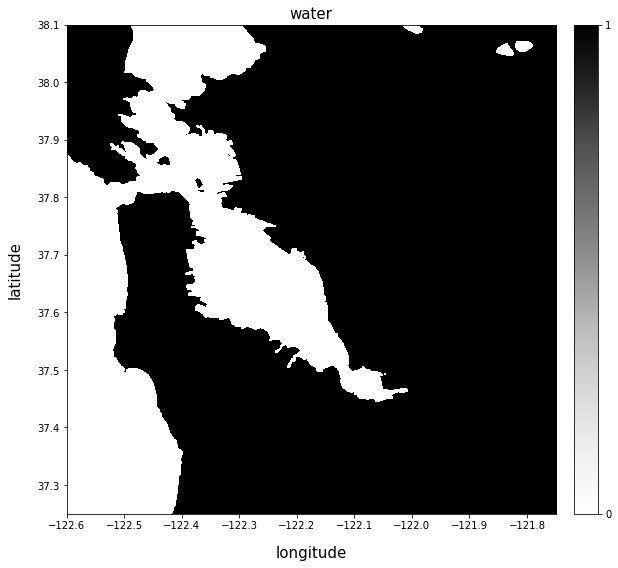

In [7]:
plot_layer('mask/watermask.msk',lay_type='water')

Below we will apply this mask to the unwrapped phase layer.

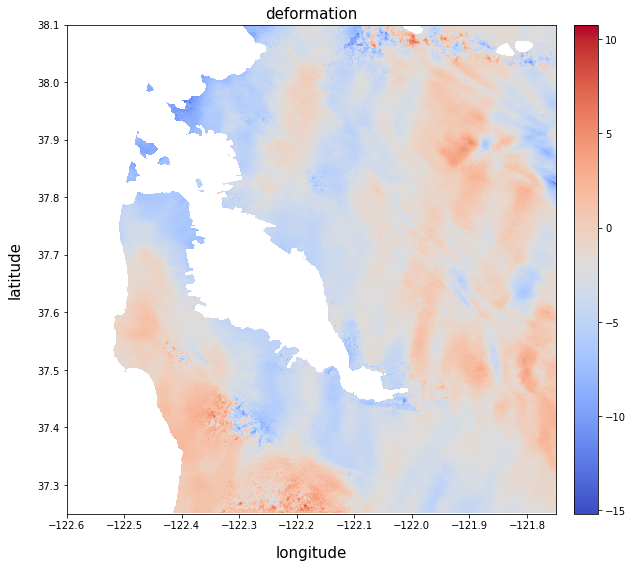

In [8]:
## view the plot
plot_layer('unwrappedPhase/20150605_20150512', 'deformation')

### View downloaded DEM

To download a 3-arc second SRTM DEM, we specified the **`-d Download`** option. By default, outputs are written to the local directory, which can be changed to another location by specifying the path with the **`-w`** option. A DEM is needed for the extraction of full resolution meta-data layers.

The DEM is cropped to the common interferometric grid, stored under local subdirectory *DEM*, and given the filename *SRTM_3arcsec.dem* (i.e. nested as *DEM/SRTM_3arcsec.dem*). Note that for consistency, if a user specifies a path to a custom DEM, the cropped version is still stored under the local subdirectory *DEM* and shares the same filename as the input. You can use gdalinfo to retrieve information on the geospatial extent of the DEM.

In [9]:
!ls DEM/SRTM*
!gdalinfo DEM/SRTM_3arcsec.dem.vrt

DEM/SRTM_3arcsec.dem               DEM/SRTM_3arcsec.hdr
DEM/SRTM_3arcsec.dem.aux.xml       DEM/SRTM_3arcsec_uncropped.dem.vrt
DEM/SRTM_3arcsec.dem.vrt
Driver: VRT/Virtual Raster
Files: DEM/SRTM_3arcsec.dem.vrt
       DEM/SRTM_3arcsec.dem
Size is 1020, 1020
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ID["EPSG",6326]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["Degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["longitude",east,
            ORDER[1],
            ANGLEUNIT["Degree",0.0174532925199433]],
        AXIS["latitude",north,
            ORDER[2],
            ANGLEUNIT["Degree",0.0174532925199433]]]
Data axis to CRS axis mapping: 1,2
Origin = (-122.599999999999994,38.100000000000001)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  Band_1=Band 1
Corner Coordinates:
Upper Left  (-122.6000000,  38.1000000) (122d36' 0.00"W, 

Execute the next cell to visualize the DEM.

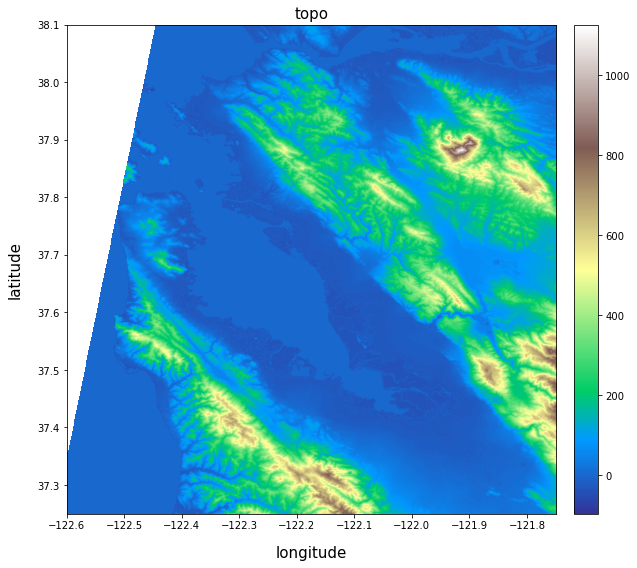

In [10]:
plot_layer('DEM/SRTM_3arcsec.dem',lay_type='topo')

### Examine *stack* files

Three VRT files *cohStack.vrt*, *connCompStack.vrt*, *unwrapStack.vrt* have been generated under the *stack* subdirectory of your specified work directory. They point to your extracted coherence, connected component, and unwrapped phase files, respectively. Let's take a look:

In [11]:
!ls stack

cohStack.vrt      connCompStack.vrt unwrapStack.vrt


Use the  **gdalinfo** to retrieve an overview of *unwrapStack.vrt*. You will see that it contains paths pointing each of the extracted interferograms in your stack, and basic projection information:

In [12]:
!gdalinfo stack/unwrapStack.vrt

Driver: VRT/Virtual Raster
Files: stack/unwrapStack.vrt
       stack/../unwrappedPhase/20150605_20150512.vrt
       stack/../unwrappedPhase/20150629_20150512.vrt
       stack/../unwrappedPhase/20150629_20150605.vrt
       stack/../unwrappedPhase/20150723_20150512.vrt
       stack/../unwrappedPhase/20150723_20150605.vrt
       stack/../unwrappedPhase/20150723_20150629.vrt
       stack/../unwrappedPhase/20150816_20150605.vrt
       stack/../unwrappedPhase/20150816_20150629.vrt
       stack/../unwrappedPhase/20150816_20150723.vrt
       stack/../unwrappedPhase/20150909_20150629.vrt
       stack/../unwrappedPhase/20150909_20150723.vrt
       stack/../unwrappedPhase/20150909_20150816.vrt
       stack/../unwrappedPhase/20151003_20150723.vrt
       stack/../unwrappedPhase/20151003_20150816.vrt
       stack/../unwrappedPhase/20151003_20150909.vrt
       stack/../unwrappedPhase/20151027_20150816.vrt
       stack/../unwrappedPhase/20151027_20150909.vrt
       stack/../unwrappedPhase/20151027_201

Band 3 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 4 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 5 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 6 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 7 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 8 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 9 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 10 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 11 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 12 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 13 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 14 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 15 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 16 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 17 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 18 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 19 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 20 Block=128x128

Band 145 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 146 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 147 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 148 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 149 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 150 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 151 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 152 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 153 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 154 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 155 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 156 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 157 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 158 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 159 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 160 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 161 Block=128x128 Type=Float32, ColorInterp=Undefin

Band 284 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 285 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 286 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 287 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 288 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 289 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 290 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 291 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 292 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 293 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 294 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 295 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 296 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 297 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 298 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 299 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 300 Block=128x128 Type=Float32, ColorInterp=Undefin

Band 423 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 424 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 425 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 426 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 427 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 428 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 429 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 430 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 431 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 432 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 433 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 434 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 435 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 436 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 437 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 438 Block=128x128 Type=Float32, ColorInterp=Undefined
Band 439 Block=128x128 Type=Float32, ColorInterp=Undefin

In [13]:
!gdalinfo stack/unwrapStack.vrt -mdd unwrappedPhase

Driver: VRT/Virtual Raster
Files: stack/unwrapStack.vrt
       stack/../unwrappedPhase/20150605_20150512.vrt
       stack/../unwrappedPhase/20150629_20150512.vrt
       stack/../unwrappedPhase/20150629_20150605.vrt
       stack/../unwrappedPhase/20150723_20150512.vrt
       stack/../unwrappedPhase/20150723_20150605.vrt
       stack/../unwrappedPhase/20150723_20150629.vrt
       stack/../unwrappedPhase/20150816_20150605.vrt
       stack/../unwrappedPhase/20150816_20150629.vrt
       stack/../unwrappedPhase/20150816_20150723.vrt
       stack/../unwrappedPhase/20150909_20150629.vrt
       stack/../unwrappedPhase/20150909_20150723.vrt
       stack/../unwrappedPhase/20150909_20150816.vrt
       stack/../unwrappedPhase/20151003_20150723.vrt
       stack/../unwrappedPhase/20151003_20150816.vrt
       stack/../unwrappedPhase/20151003_20150909.vrt
       stack/../unwrappedPhase/20151027_20150816.vrt
       stack/../unwrappedPhase/20151027_20150909.vrt
       stack/../unwrappedPhase/20151027_201

  Metadata (unwrappedPhase):
    azimuthAngle=-8.77992802893209
    Dates=20150605_20150512
    endRange=956307.125
    incidenceAngle=37.84586800841093
    lookAngle=33.50304291634067
    orbitDirection=DESCENDING
    perpendicularBaseline=121.30321573328092
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:34.000000
    Wavelength (m)=0.05546576
Band 2 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.78032272461563
    Dates=20150629_20150512
    endRange=956307.125
    incidenceAngle=37.84200295788501
    lookAngle=33.49994094097592
    orbitDirection=DESCENDING
    perpendicularBaseline=179.4199002658183
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:35.500000
    Wavelength (m)=0.05546576
Band 3 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.78032272461563
    Dates=20150629_20150605

  Metadata (unwrappedPhase):
    azimuthAngle=-8.99509230412934
    Dates=20151214_20151027
    endRange=956307.125
    incidenceAngle=38.068029264689486
    lookAngle=33.69176691263792
    orbitDirection=DESCENDING
    perpendicularBaseline=57.47478585880295
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:45.000000
    Wavelength (m)=0.05546576
Band 24 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.99509230412934
    Dates=20151214_20151120
    endRange=956307.125
    incidenceAngle=38.068029264689486
    lookAngle=33.69176691263792
    orbitDirection=DESCENDING
    perpendicularBaseline=103.95502496634414
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:45.000000
    Wavelength (m)=0.05546576
Band 25 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.994543904717638
    Dates=20160107_201

  Metadata (unwrappedPhase):
    azimuthAngle=-8.994432361502389
    Dates=20160530_20160319
    endRange=956307.125
    incidenceAngle=38.07466403096307
    lookAngle=33.69781862482851
    orbitDirection=DESCENDING
    perpendicularBaseline=-30.689020299718468
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:46.000000
    Wavelength (m)=0.05546576
Band 45 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.994432361502389
    Dates=20160530_20160412
    endRange=956307.125
    incidenceAngle=38.07466403096307
    lookAngle=33.69781862482851
    orbitDirection=DESCENDING
    perpendicularBaseline=30.690192983218036
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:46.000000
    Wavelength (m)=0.05546576
Band 46 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.994432361502389
    Dates=20160530_2

  Metadata (unwrappedPhase):
    azimuthAngle=-8.80850024477263
    Dates=20161114_20151003
    endRange=956307.125
    incidenceAngle=37.91418304669084
    lookAngle=33.558562325772954
    orbitDirection=DESCENDING
    perpendicularBaseline=85.25659158620138
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:47.500000
    Wavelength (m)=0.05546576
Band 68 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.80850024477263
    Dates=20161114_20151027
    endRange=956307.125
    incidenceAngle=37.91418304669084
    lookAngle=33.558562325772954
    orbitDirection=DESCENDING
    perpendicularBaseline=24.11577047916089
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:47.500000
    Wavelength (m)=0.05546576
Band 69 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.80850024477263
    Dates=20161114_20160

  Metadata (unwrappedPhase):
    azimuthAngle=-8.808951487907999
    Dates=20170125_20161208
    endRange=956307.125
    incidenceAngle=37.91470584831766
    lookAngle=33.559012999901434
    orbitDirection=DESCENDING
    perpendicularBaseline=54.03872036980923
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:44.000000
    Wavelength (m)=0.05546576
Band 90 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.808951487907999
    Dates=20170125_20170101
    endRange=956307.125
    incidenceAngle=37.91470584831766
    lookAngle=33.559012999901434
    orbitDirection=DESCENDING
    perpendicularBaseline=-46.434508193879424
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:44.000000
    Wavelength (m)=0.05546576
Band 91 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.808951487907999
    Dates=20170125_

  Metadata (unwrappedPhase):
    azimuthAngle=-8.809063055576424
    Dates=20170419_20160319
    endRange=956307.125
    incidenceAngle=37.91992293401116
    lookAngle=33.56370833733615
    orbitDirection=DESCENDING
    perpendicularBaseline=-48.09506568306766
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:45.000000
    Wavelength (m)=0.05546576
Band 113 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.809063055576424
    Dates=20170419_20160412
    endRange=956307.125
    incidenceAngle=37.91992293401116
    lookAngle=33.56370833733615
    orbitDirection=DESCENDING
    perpendicularBaseline=14.852530637436361
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:45.000000
    Wavelength (m)=0.05546576
Band 114 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.809063055576424
    Dates=20170419_

  Metadata (unwrappedPhase):
    azimuthAngle=-8.957855603955535
    Dates=20170618_20160530
    endRange=956307.125
    incidenceAngle=37.78143654757666
    lookAngle=33.44781232941976
    orbitDirection=DESCENDING
    perpendicularBaseline=-12.33931484878787
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:49.000000
    Wavelength (m)=0.05546576
Band 134 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957855603955535
    Dates=20170618_20170501
    endRange=956307.125
    incidenceAngle=37.78143654757666
    lookAngle=33.44781232941976
    orbitDirection=DESCENDING
    perpendicularBaseline=-13.310812203990343
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:49.000000
    Wavelength (m)=0.05546576
Band 135 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957855603955535
    Dates=20170618

  Metadata (unwrappedPhase):
    azimuthAngle=-8.956948364311865
    Dates=20170805_20170630
    endRange=956307.125
    incidenceAngle=37.776131205230556
    lookAngle=33.443250169638176
    orbitDirection=DESCENDING
    perpendicularBaseline=105.077408207573
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:52.000000
    Wavelength (m)=0.05546576
Band 155 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.956948364311865
    Dates=20170805_20170712
    endRange=956307.125
    incidenceAngle=37.776131205230556
    lookAngle=33.443250169638176
    orbitDirection=DESCENDING
    perpendicularBaseline=70.30384610442499
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:52.000000
    Wavelength (m)=0.05546576
Band 156 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.956948364311865
    Dates=20170805

  Metadata (unwrappedPhase):
    azimuthAngle=-8.959150888659224
    Dates=20171028_20160927
    endRange=956307.125
    incidenceAngle=37.77877237922267
    lookAngle=33.44530094586887
    orbitDirection=DESCENDING
    perpendicularBaseline=-41.524190431664366
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:55.000000
    Wavelength (m)=0.05546576
Band 178 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.959150888659224
    Dates=20171028_20161021
    endRange=956307.125
    incidenceAngle=37.77877237922267
    lookAngle=33.44530094586887
    orbitDirection=DESCENDING
    perpendicularBaseline=49.37152046327167
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:55.000000
    Wavelength (m)=0.05546576
Band 179 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.959150888659224
    Dates=20171028_

  Metadata (unwrappedPhase):
    azimuthAngle=-8.957726555797258
    Dates=20171215_20171203
    endRange=956307.125
    incidenceAngle=37.7776770591736
    lookAngle=33.44429828087804
    orbitDirection=DESCENDING
    perpendicularBaseline=4.085578700791481
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:53.000000
    Wavelength (m)=0.05546576
Band 202 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.95834956864115
    Dates=20171227_20161114
    endRange=956307.125
    incidenceAngle=37.78379047447855
    lookAngle=33.44950316502495
    orbitDirection=DESCENDING
    perpendicularBaseline=-115.96794616452114
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:53.000000
    Wavelength (m)=0.05546576
Band 203 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.95834956864115
    Dates=20171227_201

  Metadata (unwrappedPhase):
    azimuthAngle=-8.957998968811664
    Dates=20180213_20180120
    endRange=956307.125
    incidenceAngle=37.774934787981955
    lookAngle=33.44203553605175
    orbitDirection=DESCENDING
    perpendicularBaseline=8.076604152980613
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:51.000000
    Wavelength (m)=0.05546576
Band 226 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957998968811664
    Dates=20180213_20180201
    endRange=956307.125
    incidenceAngle=37.774934787981955
    lookAngle=33.44203553605175
    orbitDirection=DESCENDING
    perpendicularBaseline=-8.101778507232659
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:51.000000
    Wavelength (m)=0.05546576
Band 227 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958518185596247
    Dates=20180225

  Metadata (unwrappedPhase):
    azimuthAngle=-8.957126640597826
    Dates=20180426_20180321
    endRange=956307.125
    incidenceAngle=37.779803606180046
    lookAngle=33.44641774096471
    orbitDirection=DESCENDING
    perpendicularBaseline=101.4357674015678
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:53.000000
    Wavelength (m)=0.05546576
Band 250 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957126640597826
    Dates=20180426_20180402
    endRange=956307.125
    incidenceAngle=37.779803606180046
    lookAngle=33.44641774096471
    orbitDirection=DESCENDING
    perpendicularBaseline=6.0372473570981935
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:53.000000
    Wavelength (m)=0.05546576
Band 251 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957126640597826
    Dates=20180426

  Metadata (unwrappedPhase):
    azimuthAngle=-8.956792177941628
    Dates=20180625_20170606
    endRange=956307.125
    incidenceAngle=37.77771360188845
    lookAngle=33.444583508649835
    orbitDirection=DESCENDING
    perpendicularBaseline=-17.414715305513706
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:56.000000
    Wavelength (m)=0.05546576
Band 273 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.956792177941628
    Dates=20180625_20170618
    endRange=956307.125
    incidenceAngle=37.77771360188845
    lookAngle=33.444583508649835
    orbitDirection=DESCENDING
    perpendicularBaseline=57.054217037401756
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:56.000000
    Wavelength (m)=0.05546576
Band 274 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.956792177941628
    Dates=201806

  Metadata (unwrappedPhase):
    azimuthAngle=-8.956563313480324
    Dates=20180812_20180731
    endRange=956307.125
    incidenceAngle=37.779045379113555
    lookAngle=33.445739993199574
    orbitDirection=DESCENDING
    perpendicularBaseline=95.14480319003825
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:59.000000
    Wavelength (m)=0.05546576
Band 297 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957127176315673
    Dates=20180824_20170805
    endRange=956307.125
    incidenceAngle=37.78205937605635
    lookAngle=33.44834339473895
    orbitDirection=DESCENDING
    perpendicularBaseline=-89.37117015977617
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:00.000000
    Wavelength (m)=0.05546576
Band 298 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957127176315673
    Dates=20180824

  Metadata (unwrappedPhase):
    azimuthAngle=-8.957649659531324
    Dates=20181011_20180905
    endRange=956307.125
    incidenceAngle=37.77717379326761
    lookAngle=33.44396648522809
    orbitDirection=DESCENDING
    perpendicularBaseline=19.005000100927305
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:01.000000
    Wavelength (m)=0.05546576
Band 320 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957649659531324
    Dates=20181011_20180917
    endRange=956307.125
    incidenceAngle=37.77717379326761
    lookAngle=33.44396648522809
    orbitDirection=DESCENDING
    perpendicularBaseline=61.19942116447783
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:01.000000
    Wavelength (m)=0.05546576
Band 321 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957649659531324
    Dates=20181011_2

  Metadata (unwrappedPhase):
    azimuthAngle=-8.958587388760634
    Dates=20181128_20181116
    endRange=956307.125
    incidenceAngle=37.782437227998265
    lookAngle=33.44836781382079
    orbitDirection=DESCENDING
    perpendicularBaseline=-30.24106492880384
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:00.000000
    Wavelength (m)=0.05546576
Band 342 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.95818877702782
    Dates=20181210_20171121
    endRange=956307.125
    incidenceAngle=37.77822136782441
    lookAngle=33.44473847493464
    orbitDirection=DESCENDING
    perpendicularBaseline=-32.625549955406626
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:00.000000
    Wavelength (m)=0.05546576
Band 343 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.95818877702782
    Dates=20181210_

  Metadata (unwrappedPhase):
    azimuthAngle=-8.958983666501048
    Dates=20190127_20190115
    endRange=956307.125
    incidenceAngle=37.77768375999052
    lookAngle=33.44431824433175
    orbitDirection=DESCENDING
    perpendicularBaseline=59.569696990102
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:58.000000
    Wavelength (m)=0.05546576
Band 367 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958038419847073
    Dates=20190208_20180120
    endRange=956307.125
    incidenceAngle=37.779408891191366
    lookAngle=33.44580268473757
    orbitDirection=DESCENDING
    perpendicularBaseline=-61.25960805252012
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:58.000000
    Wavelength (m)=0.05546576
Band 368 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958038419847073
    Dates=20190208_20

  Metadata (unwrappedPhase):
    azimuthAngle=-8.958715130925667
    Dates=20190328_20190220
    endRange=956307.125
    incidenceAngle=37.780892576765915
    lookAngle=33.44739720502841
    orbitDirection=DESCENDING
    perpendicularBaseline=-80.97447789921941
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:58.000000
    Wavelength (m)=0.05546576
Band 390 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958715130925667
    Dates=20190328_20190304
    endRange=956307.125
    incidenceAngle=37.780892576765915
    lookAngle=33.44739720502841
    orbitDirection=DESCENDING
    perpendicularBaseline=-134.09105239899066
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:07:58.000000
    Wavelength (m)=0.05546576
Band 391 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958715130925667
    Dates=201903

  Metadata (unwrappedPhase):
    azimuthAngle=-8.957739471906594
    Dates=20190527_20180520
    endRange=956307.125
    incidenceAngle=37.77991168991273
    lookAngle=33.446565865505114
    orbitDirection=DESCENDING
    perpendicularBaseline=40.59135782959971
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:00.000000
    Wavelength (m)=0.05546576
Band 414 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957739471906594
    Dates=20190527_20190421
    endRange=956307.125
    incidenceAngle=37.77991168991273
    lookAngle=33.446565865505114
    orbitDirection=DESCENDING
    perpendicularBaseline=-80.09641746953422
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:00.000000
    Wavelength (m)=0.05546576
Band 415 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.957739471906594
    Dates=20190527

  Metadata (unwrappedPhase):
    azimuthAngle=-8.958076199056649
    Dates=20190726_20180719
    endRange=956307.125
    incidenceAngle=37.78275245790058
    lookAngle=33.44891557616259
    orbitDirection=DESCENDING
    perpendicularBaseline=7.113753423999675
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:04.000000
    Wavelength (m)=0.05546576
Band 437 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958076199056649
    Dates=20190726_20190620
    endRange=956307.125
    incidenceAngle=37.78275245790058
    lookAngle=33.44891557616259
    orbitDirection=DESCENDING
    perpendicularBaseline=-18.595413814189467
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:04.000000
    Wavelength (m)=0.05546576
Band 438 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958076199056649
    Dates=20190726_

  Metadata (unwrappedPhase):
    azimuthAngle=-8.958280295978186
    Dates=20190924_20190831
    endRange=956307.125
    incidenceAngle=37.777000220681025
    lookAngle=33.44384717748234
    orbitDirection=DESCENDING
    perpendicularBaseline=28.26446747297221
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:07.000000
    Wavelength (m)=0.05546576
Band 460 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958280295978186
    Dates=20190924_20190912
    endRange=956307.125
    incidenceAngle=37.777000220681025
    lookAngle=33.44384717748234
    orbitDirection=DESCENDING
    perpendicularBaseline=75.10608449155978
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:07.000000
    Wavelength (m)=0.05546576
Band 461 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958861876113208
    Dates=20191006_

  Metadata (unwrappedPhase):
    azimuthAngle=-8.958897808785387
    Dates=20191205_20181128
    endRange=956307.125
    incidenceAngle=37.783164026283565
    lookAngle=33.44893369211362
    orbitDirection=DESCENDING
    perpendicularBaseline=-11.315567392086699
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:07.000000
    Wavelength (m)=0.05546576
Band 482 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958897808785387
    Dates=20191205_20191030
    endRange=956307.125
    incidenceAngle=37.783164026283565
    lookAngle=33.44893369211362
    orbitDirection=DESCENDING
    perpendicularBaseline=-86.17565929551837
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:07.000000
    Wavelength (m)=0.05546576
Band 483 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.958897808785387
    Dates=201912

  Metadata (unwrappedPhase):
    azimuthAngle=-8.95799698617294
    Dates=20200310_20200203
    endRange=956307.125
    incidenceAngle=37.77267241381439
    lookAngle=33.44024894112039
    orbitDirection=DESCENDING
    perpendicularBaseline=117.92190682260613
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:04.000000
    Wavelength (m)=0.05546576
Band 506 Block=128x128 Type=Float32, ColorInterp=Undefined
  Metadata (unwrappedPhase):
    azimuthAngle=-8.95799698617294
    Dates=20200310_20200227
    endRange=956307.125
    incidenceAngle=37.77267241381439
    lookAngle=33.44024894112039
    orbitDirection=DESCENDING
    perpendicularBaseline=124.78116139709233
    slantRangeSpacing=2.329562187194824
    startRange=798980.125
    UTCTime (HH:MM:SS.ss)=14:08:04.000000
    Wavelength (m)=0.05546576


We can now use our earlier defined plotting function to visualize one of the interferograms in your stack.

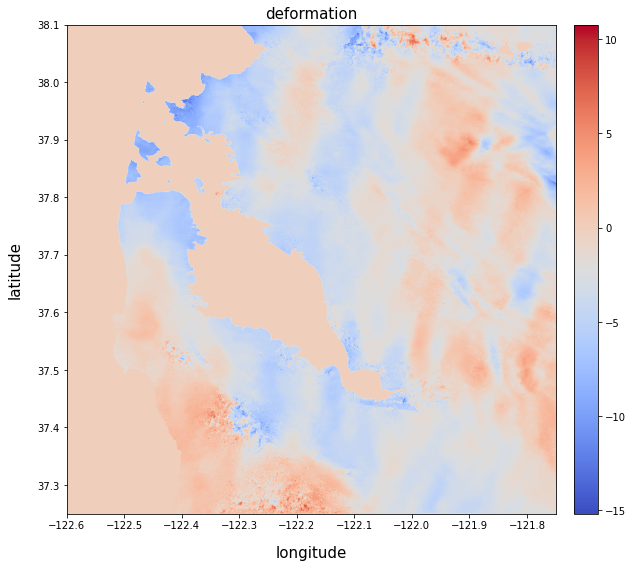

In [14]:
plot_layer('stack/unwrapStack.vrt', 'deformation', n_bands=1)